# Sample training script with naive competitive self-play.

# Switch directory in Google drive so as to import CDA env.


In [1]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

# %cd "/root/ray_results/"
# !ls -l
# #!rm -rf PPO_continuousDoubleAuction-v0_*
# !ls -l
# !pwd

# %cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
# !ls -l

# #!pip install -r requirements.txt

# #!pip install tensorflow==2.2.0
# #!pip install ray[rllib]==0.8.5

# #!pip show tensorflow
# #!pip show ray

# #!pip freeze > requirements.txt

# Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

from collections import defaultdict
from typing import Dict

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import ppo

from ray.rllib.agents.ppo.ppo import PPOTrainer
import ray.rllib.algorithms.ppo as ppo

from ray.rllib.env import BaseEnv
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.tune.logger import pretty_print

/home/ray/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/ray/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/ray/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/ray/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/home/ray/anaconda3/lib/python3

In [3]:
import sys
if "../" not in sys.path:
    sys.path.append("../")
    
print(sys.path)

['/home/ray/anaconda3/lib/python3.7/site-packages/ray/thirdparty_files', '/home/ray/anaconda3/lib/python3.7/site-packages/ray/pickle5_files', '/home/ray/gym-continuousDoubleAuction/gym_continuousDoubleAuction', '/home/ray/anaconda3/lib/python37.zip', '/home/ray/anaconda3/lib/python3.7', '/home/ray/anaconda3/lib/python3.7/lib-dynload', '', '/home/ray/anaconda3/lib/python3.7/site-packages', '/home/ray/gym-continuousDoubleAuction', '/home/ray/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ray/.ipython', '../']


In [4]:
!pwd

/home/ray/gym-continuousDoubleAuction/gym_continuousDoubleAuction


In [5]:
from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies, create_train_policy_list
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import storage
from gym_continuousDoubleAuction.train.callbk.callbk_handler import store_eps_hist_data
from gym_continuousDoubleAuction.train.logger.log_handler import create_dir, log_g_store, load_g_store
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_storage, plot_LOB_subplot, plot_sum_ord_imb, plot_mid_prices
from gym_continuousDoubleAuction.train.helper.helper import ord_imb, sum_ord_imb, mid_price

# tf = try_import_tf()

# Global


In [6]:
# CDA_env args
num_agents = 4
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 100000
max_step = 512 #4096 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = True 

In [7]:
# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
#num_cpus = 0.25                                
num_gpus = 0.75 #0                       
num_cpus_per_worker = 0.25                                
num_gpus_per_worker = 0
num_workers = 1
num_envs_per_worker = 1
batch_mode = "complete_episodes" 
rollout_fragment_length = 128
train_batch_size = max_step
sgd_minibatch_size = 256
num_iters = 1

train_policy_list =  ['policy_0', 'policy_1']


In [8]:
# log_base_dir = "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/"
log_base_dir = "/home/ray/gym-continuousDoubleAuction/results/"
log_dir = log_base_dir + "ray_results/"

# Chkpt & restore
local_dir = log_base_dir + "chkpt/"
chkpt_freq = 10
chkpt = 320
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False # True / False

# log & load 
log_g_store_dir = log_base_dir + "log_g_store/"
print(f'log_base_dir:{log_base_dir}')
print(f'log_g_store_dir:{log_g_store_dir}')
create_dir(log_base_dir)    
create_dir(log_g_store_dir)    

log_base_dir:/home/ray/gym-continuousDoubleAuction/results/
log_g_store_dir:/home/ray/gym-continuousDoubleAuction/results/log_g_store/
Folder creation failed or folder already exists: /home/ray/gym-continuousDoubleAuction/results/
Folder creation failed or folder already exists: /home/ray/gym-continuousDoubleAuction/results/log_g_store/


In [9]:
# from ray.tune.registry import register_env

# def env_creator(env_config):
#     return MyEnv(...)  # return an env instance

# register_env("my_env", env_creator)
# algo = ppo.PPO(env="my_env")

In [10]:
# class MultiEnv(gym.Env):
#     def __init__(self, env_config):
#         # pick actual env based on worker and env indexes
#         self.env = gym.make(
#             choose_env_for(env_config.worker_index, env_config.vector_index))
#         self.action_space = self.env.action_space
#         self.observation_space = self.env.observation_space
#     def reset(self):
#         return self.env.reset()
#     def step(self, action):
#         return self.env.step(action)

# register_env("multienv", lambda config: MultiEnv(config))

In [11]:
# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(
    num_of_traders, 
    init_cash, 
    tick_size, 
    tape_display_length, 
    max_step, 
    is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# def env_creator(env_config):
#     return continuousDoubleAuctionEnv(
#         num_of_traders, 
#         init_cash, 
#         tick_size, 
#         tape_display_length,
#         max_step-1, 
#         is_render)

# register CDA env with RLlib 
register_env(
    "continuousDoubleAuction-v0", 
    lambda _: continuousDoubleAuctionEnv(
        num_of_traders, 
        init_cash, 
        tick_size, 
        tape_display_length,
        max_step-1, 
        is_render))
# register_env(
#     "continuousDoubleAuction-v0", 
#     env_creator)
# register_env("multienv", lambda config: MultiEnv(config))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.shutdown()
assert not ray.is_initialized()
# ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 
ray.init()
assert ray.is_initialized()

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
# g_store = storage.options(name="g_store", detached=True).remote(num_agents)
g_store = storage.options(name="g_store", lifetime="detached").remote(num_agents)

2022-11-20 05:44:28,115	INFO worker.py:1515 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2022-11-20 05:44:30,599	WARNING worker.py:1829 -- It looks like you're creating a detached actor in an anonymous namespace. In order to access this actor in the future, you will need to explicitly connect to this namespace with ray.init(namespace="c4bf55a2-84f3-4453-a64a-8647d77e9206", ...)


# Policies

In [12]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            return "policy_{}".format(i)                

policies: {'policy_0': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_1': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_2': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_3': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {})}


# Call back.

In [13]:
class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self, worker: RolloutWorker, base_env: BaseEnv,
                         policies: Dict[str, Policy],
                         episode: MultiAgentEpisode, **kwargs):
        """
        info["episode"] is a MultiAgentEpisode object.

        user_data dicts at 100000 items max, will auto replace old with new item at 1st index.
        hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
        """
        #print("on_episode_start {}, _agent_to_policy {}".format(episode.episode_id, episode._agent_to_policy))

        prefix = "agt_"
        for i in range(num_agents):
            episode.user_data[prefix + str(i) + "_obs"] = []
            episode.user_data[prefix + str(i) + "_act"] = []
            episode.user_data[prefix + str(i) + "_reward"] = []
            episode.user_data[prefix + str(i) + "_NAV"] = []
            episode.user_data[prefix + str(i) + "_num_trades"] = []

            episode.hist_data[prefix + str(i) + "_reward"] = []
            episode.hist_data[prefix + str(i) + "_NAV"] = []
            episode.hist_data[prefix + str(i) + "_num_trades"] = []

    def on_episode_step(self, worker: RolloutWorker, base_env: BaseEnv,
                        episode: MultiAgentEpisode, **kwargs):
        """
        pole_angle = abs(episode.last_observation_for()[2])
        raw_angle = abs(episode.last_raw_obs_for()[2])
        assert pole_angle == raw_angle
        episode.user_data["pole_angles"].append(pole_angle)
        """

        prefix = "agt_"
        for i in range(num_agents):
            obs = episode.last_raw_obs_for(i)
            #obs = episode.last_observation_for(i)
            act = episode.last_action_for(i)
            reward = episode.last_info_for(i).get("reward")
            NAV = episode.last_info_for(i).get("NAV")
            NAV = None if NAV is None else float(NAV)
            num_trades = episode.last_info_for(i).get("num_trades")
        
            if reward is None:      # goto next agent.
                continue

            episode.user_data[prefix + str(i) + "_obs"].append(obs)    
            episode.user_data[prefix + str(i) + "_act"].append(act)    
            episode.user_data[prefix + str(i) + "_reward"].append(reward)    
            episode.user_data[prefix + str(i) + "_NAV"].append(NAV)    
            episode.user_data[prefix + str(i) + "_num_trades"].append(num_trades)          

    def on_episode_end(self, worker: RolloutWorker, base_env: BaseEnv,
                       policies: Dict[str, Policy], episode: MultiAgentEpisode,
                       **kwargs):
        #print("on_episode_end {}, episode.agent_rewards {}".format(episode.episode_id, episode.agent_rewards))
        """
        arg: {"env": .., "episode": ...}
        """

#         g_store = ray.util.get_actor("g_store")
        g_store = ray.get_actor("g_store")

        prefix = "agt_"
        for agt_id in range(num_agents):
            obs_key = prefix + str(agt_id) + "_obs"
            act_key = prefix + str(agt_id) + "_act"
            reward_key = prefix + str(agt_id) + "_reward"
            NAV_key = prefix + str(agt_id) + "_NAV"
            num_trades_key = prefix + str(agt_id) + "_num_trades"      

            # store into episode.hist_data
            store_eps_hist_data(episode, reward_key)
            store_eps_hist_data(episode, NAV_key)
            store_eps_hist_data(episode, num_trades_key)

            # store step data
            obs = episode.user_data[obs_key]
            act = episode.user_data[act_key]
            reward = episode.user_data[reward_key]
            NAV = episode.user_data[NAV_key]
            num_trades = episode.user_data[num_trades_key]
            ray.get(g_store.store_agt_step.remote(agt_id, obs, act, reward, NAV, num_trades))       
        
            # Store episode data.   
            eps_reward = np.sum(reward)
            eps_NAV = np.sum(NAV)
            eps_num_trades = np.sum(num_trades)
            ray.get(g_store.store_agt_eps.remote(agt_id, eps_reward, eps_NAV, eps_num_trades))

        ray.get(g_store.inc_eps_counter.remote())  

    def on_sample_end(self, worker: RolloutWorker, samples: SampleBatch,
                      **kwargs):
        """
        arg: {"samples": .., "worker": ...}

        Notes:
            https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py        
        """
        #print("on_sample_end returned sample batch of size {}".format(samples.count))

        """
        MultiAgentBatch_obj = info["samples"]
        MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
        MultiAgentBatch_count = MultiAgentBatch_obj.count

        access_sample_batches(MultiAgentBatch_policy_batches)
        print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
        print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object
        """

    def on_train_result(self, trainer, result: dict, **kwargs):
        """
        info["trainer"] is the trainer object.

        info["result"] contains a bunch of info such as episodic rewards for 
        each policy in info["result"][hist_stats] dictionary.
        """
        #print("trainer.train() result: {} -> {} episodes".format(trainer, result["episodes_this_iter"]))
        # you can mutate the result dict to add new fields to return
        result["callback_ok"] = True
        #print("on_train_result result", result)
    
        train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
        max_reward_ind = get_max_reward_ind(result, train_policies_name)
        max_reward_policy_name = train_policies_name[max_reward_ind]
        cp_weight(trainer, train_policies_name, max_reward_policy_name)    

#         g_store = ray.util.get_actor("g_store")   
        g_store = ray.get_actor("g_store")      

        prefix = "policy_policy_"
        suffix = "_reward"
        hist_stats = result["hist_stats"]
        eps_this_iter = result["episodes_this_iter"]
        for agt_id in range(num_agents):
            key = prefix + str(agt_id) + suffix
            for i in range(eps_this_iter):
                ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

        #print("on_train_result info['result'] {}".format(info["result"]))     

    def on_postprocess_trajectory(
            self, worker: RolloutWorker, episode: MultiAgentEpisode,
            agent_id: str, policy_id: str, policies: Dict[str, Policy],
            postprocessed_batch: SampleBatch,
            original_batches: Dict[str, SampleBatch], **kwargs):
        #print("postprocessed {}, {}, {}, {} steps".format(episode, agent_id, policy_id, postprocessed_batch.count))
        """
        if "num_batches" not in episode.custom_metrics:
            episode.custom_metrics["num_batches"] = 0
        episode.custom_metrics["num_batches"] += 1        

        arg: {"agent_id": ..., "episode": ...,
              "pre_batch": (before processing),
              "post_batch": (after processing),
              "all_pre_batches": (other agent ids)}

        # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
        Dictionaries in a sample_obj, k:
            t
            eps_id
            agent_index
            obs
            actions
            rewards
            prev_actions
            prev_rewards
            dones
            infos
            new_obs
            action_prob
            action_logp
            vf_preds
            behaviour_logits
            unroll_id       
        """

        """
        policy_obj = info["pre_batch"][0]
        sample_obj = info["pre_batch"][1]    
        agt_id = info["agent_id"]
        eps_id = info["episode"].episode_id
        """        

# RLlib config

In [14]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
    config["num_gpus"] = num_gpus     # trainer
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = batch_mode       # "complete_episodes" / "truncate_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = MyCallbacks
    config["output"] = log_dir
    config["disable_env_checking"]=True

    return config

# Train


In [15]:
def go_train(config):    
#     trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    trainer = ppo.PPO(config=config, env="continuousDoubleAuction-v0")
#     trainer = ppo.PPO(env="continuousDoubleAuction-v0")

    if is_restore == True:
        trainer.restore(restore_path) 

#     g_store = ray.util.get_actor("g_store")    
    g_store = ray.get_actor("g_store")    
    
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print(pretty_print(result)) # includes result["custom_metrics"]
        print("training loop = {} of {}".format(i + 1, num_iters))            
        print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))

        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)

    print("result['experiment_id']", result["experiment_id"])
    
    return result["experiment_id"]
    
# run everything
experiment_id = go_train(get_config())            

/home/ray/anaconda3/lib/python3.7/site-packages/requests_toolbelt/_compat.py:56: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from requests.packages.urllib3.contrib.pyopenssl \
2022-11-20 05:44:31,483	INFO algorithm.py:1872 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-11-20 05:44:31,487	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/ray/anaconda3/lib/python3.7/site-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required o

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 0 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:100000, cash:100000, cash_on_hold:0, trade_val:0, pos_val:0, net_pos:0, profit:0
(RolloutWorker pid=3570) ID:1, nav:100000, cash:100000, cash_on_hold:0, trade_val:0, pos_val:0, net_pos:0, profit:0
(RolloutWorker pid=3570) ID:2, nav:100000, cash:100000, cash_on_hold:0, trade_val:0, pos_val:0, net_pos:0, profit:0
(RolloutWorker pid=3570) ID:3, nav:100000, cash:100000, cash_on_hold:0, trade_val:0, pos_val:0, net_pos:0, profit:0
(RolloutWorker pid=3570) sum:400000
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 1 **************************************************
(RolloutWorker pid=3570) 
(RolloutWork

(RolloutWorker pid=3570) 8
(RolloutWorker pid=3570) 8
(RolloutWorker pid=3570) 8
(RolloutWorker pid=3570) 8
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 9
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 24 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:107734, cash:106052, cash_on_hold:4481, trade_val:10533, pos_val:-2799, net_pos:-311, profit:7734
(RolloutWorker pid=3570) ID:1, nav:104876, cash:89777, cash_on_hold:5266, trade_val:-4957, pos_val:-81, net_pos:-9, profit:4876
(RolloutWorker pid=3570) ID:2, nav:108255, cash:104392, cash_on_hold:6986, trade_val:11378, pos_val:-3123, net_pos:-347, profit:8255
(RolloutWorker pid=3570) ID:3, nav:89049, cash:61959, cash_on_hold:21087, trade_val:-16954, pos_val:6003, net_pos:667, profit:-10951
(RolloutWorker pid=3570) sum:409914
(RolloutWorker pid=3570) 60
(R

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 48 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:79953, cash:65603, cash_on_hold:665, trade_val:-33732, pos_val:13685, net_pos:391, profit:-20047
(RolloutWorker pid=3570) ID:1, nav:95085, cash:45093, cash_on_hold:23602, trade_val:-31305, pos_val:26390, net_pos:754, profit:-4915
(RolloutWorker pid=3570) ID:2, nav:99464, cash:82667, cash_on_hold:43257, trade_val:25924, pos_val:-26460, net_pos:-756, profit:-536
(RolloutWorker pid=3570) ID:3, nav:125498, cash:139113, cash_on_hold:0, trade_val:39113, pos_val:-13615, net_pos:-389, profit:25498
(RolloutWorker pid=3570) sum:400000
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 49 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:79953, cash:65603

(RolloutWorker pid=3570) 40
(RolloutWorker pid=3570) 40
(RolloutWorker pid=3570) 40
(RolloutWorker pid=3570) 40
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 72 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:79008, cash:62463, cash_on_hold:665, trade_val:-36872, pos_val:15880, net_pos:397, profit:-20992
(RolloutWorker pid=3570) ID:1, nav:98677, cash:46927, cash_on_hold:30710, trade_val:-22363, pos_val:21040, net_pos:526, profit:-1323
(RolloutWorker pid=3570) ID:2, nav:89617, cash:51149, cash_on_hold:66908, trade_val:18057, pos_val:-28440, net_pos:-711, profit:-10383
(RolloutWorker pid=3570) ID:3, nav:132698, cash:79827, cash_on_hold:61351, trade_val:41178, pos_val:-8480, net_pos:-212, profit:32698
(RolloutWorker pid=3570) sum:400000
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 43
(RolloutWorker 

(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 102 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:79567, cash:40716, cash_on_hold:37871, trade_val:-21413, pos_val:980, net_pos:28, profit:-20433
(RolloutWorker pid=3570) ID:1, nav:95467, cash:19123, cash_on_hold:49534, trade_val:-31343, pos_val:26810, net_pos:766, profit:-4533
(RolloutWorker pid=3570) ID:2, nav:92004, cash:-8902, cash_on_hold:121346, trade_val:12444, pos_val:-20440, net_pos:-584, profit:-7996
(RolloutWorker pid=3570) ID:3, nav:132962, cash:90641, cash_on_hold:49671

(RolloutWorker pid=3570) 51
(RolloutWorker pid=3570) 51
(RolloutWorker pid=3570) 51
(RolloutWorker pid=3570) 51
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 127 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:77153, cash:4383, cash_on_hold:67364, trade_val:-28253, pos_val:5406, net_pos:106, profit:-22847
(RolloutWorker pid=3570) ID:1, nav:108359, cash:-23078, cash_on_hold:115423, trade_val:-7655, pos_val:16014, net_pos:314, profit:8359
(RolloutWorker pid=3570) ID:2, nav:84867, cash:-51005, cash_on_hold:152651, trade_val:1646, pos_val:-16779, net_pos:-329, profit:-15133
(RolloutWorker pid=3570) ID:3, nav:129621, cash:46506, cash_on_hold:87756, trade_val:34262, pos_val:-4641, net_pos:-91, profit:29621
(RolloutWorker pid=3570) sum:400000
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 128 **********

(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 50
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 154 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:76316, cash:-50889, cash_on_hold:120255, trade_val:-30634, pos_val:6950, net_pos:139, profit:-23684
(RolloutWorker pid=3570) ID:1, nav:107739, cash:2486, cash_on_hold:96703, trade_val:-811, pos_val:8550, net_pos:171, profit:7739
(RolloutWorker pid=3570) ID:2, nav:85360, cash:-79948, cash_on_hold:179038, trade_val:-910, pos_val:-15550, net_pos:-311, profit:-14640
(RolloutWorker pid=3570) ID:3, nav:67695, cash:22057, cash_on_hold:110298, trade_val:32355, pos_val:50, net_pos:1, profit:-32305
(RolloutWorker pid=3570) sum:337110
(RolloutWorker pid=

(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 181 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:75337, cash:-71284, cash_on_hold:142301, trade_val:-28983, pos_val:4320, net_pos:90, profit:-24663
(RolloutWorker pid=3570) ID:1, nav:106938, cash:-36880, cash_on_hold:134554, trade_val:-2326, pos_val:9264, net_pos:193, profit:6938
(RolloutWorker pid=3570) ID:2, nav:83448, cash:-123779, cash_on_hold:225995, trade_val:2216, pos_val:-18768, net_pos:-391, profit:-16552
(RolloutWorker pid=3570) ID:3, nav:76091, cash:7077, cash_on_hold:122016, trade_val:29093, pos_val:5184, net_pos:108, profit:-23909
(RolloutWorker pid=3570) sum:341814
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWork

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 206 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:122365, cash:-76210, cash_on_hold:151541, trade_val:-24669, pos_val:-2304, net_pos:-48, profit:22365
(RolloutWorker pid=3570) ID:1, nav:106457, cash:-66047, cash_on_hold:159352, trade_val:-6695, pos_val:13152, net_pos:274, profit:6457
(RolloutWorker pid=3570) ID:2, nav:81813, cash:-108062, cash_on_hold:220307, trade_val:12245, pos_val:-30432, net_pos:-634, profit:-18187
(RolloutWorker pid=3570) ID:3, nav:100465, cash:-6884, cash_on_hold:126003, trade_val:19119, pos_val:19584, net_pos:408, profit:465
(RolloutWorker pid=3570) sum:411100
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 48
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 207 *****

(RolloutWorker pid=3570) 34
(RolloutWorker pid=3570) 34
(RolloutWorker pid=3570) 34
(RolloutWorker pid=3570) 34
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 232 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:72467, cash:-111241, cash_on_hold:177928, trade_val:-33313, pos_val:5780, net_pos:170, profit:-27533
(RolloutWorker pid=3570) ID:1, nav:107185, cash:-98488, cash_on_hold:207679, trade_val:9191, pos_val:-2006, net_pos:-59, profit:7185
(RolloutWorker pid=3570) ID:2, nav:89961, cash:-123205, cash_on_hold:235538, trade_val:12333, pos_val:-22372, net_pos:-658, profit:-10039
(RolloutWorker pid=3570) ID:3, nav:106809, cash:-20313, cash_on_hold:132102, trade_val:11789, pos_val:18598, net_pos:547, profit:6809
(RolloutWorker pid=3570) sum:376422
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 233 ****

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 260 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:73897, cash:-142477, cash_on_hold:209862, trade_val:-32615, pos_val:6512, net_pos:148, profit:-26103
(RolloutWorker pid=3570) ID:1, nav:106706, cash:-189993, cash_on_hold:298283, trade_val:8290, pos_val:-1584, net_pos:-36, profit:6706
(RolloutWorker pid=3570) ID:2, nav:82953, cash:-130277, cash_on_hold:246582, trade_val:16305, pos_val:-33352, net_pos:-758, profit:-17047
(RolloutWorker pid=3570) ID:3, nav:120404, cash:-68649, cash_on_hold:176669, trade_val:8020, pos_val:28424, net_pos:646, profit:20404
(RolloutWorker pid=3570) sum:383960
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(RolloutWorker pid=3570) 33
(Rollo

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 288 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:123523, cash:-114426, cash_on_hold:189398, trade_val:-25028, pos_val:-1505, net_pos:-35, profit:23523
(RolloutWorker pid=3570) ID:1, nav:108266, cash:-251830, cash_on_hold:350249, trade_val:-1581, pos_val:9847, net_pos:229, profit:8266
(RolloutWorker pid=3570) ID:2, nav:83398, cash:-147589, cash_on_hold:260227, trade_val:12638, pos_val:-29240, net_pos:-680, profit:-16602
(RolloutWorker pid=3570) ID:3, nav:106927, cash:-83838, cash_on_hold:197809, trade_val:13971, pos_val:20898, net_pos:486, profit:6927
(RolloutWorker pid=3570) sum:422114
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 43
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 289 **

(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 311 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:124942, cash:-138127, cash_on_hold:212482, trade_val:-25645, pos_val:-703, net_pos:-19, profit:24942
(RolloutWorker pid=3570) ID:1, nav:106597, cash:-239546, cash_on_hold:336671, trade_val:-2875, pos_val:9472, net_pos:256, profit:6597
(RolloutWorker pid=3570) ID:2, nav:87201, cash:-149403, cash_on_hold:261135, trade_val:11732, pos_val:-24531, net_pos:-663, profit:-12799
(RolloutWorker pid=3570) ID:3, nav:98974, cash:-105387, cash_on_hold:222175, trade_val:16788, pos_val:15762, net_pos:426, profit:-1026
(RolloutWorker pid=3570) sum:417714
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(Roll

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 322 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:117825, cash:-206942, cash_on_hold:285127, trade_val:-21815, pos_val:-3990, net_pos:-95, profit:17825
(RolloutWorker pid=3570) ID:1, nav:107637, cash:-245941, cash_on_hold:342406, trade_val:-3535, pos_val:11172, net_pos:266, profit:7637
(RolloutWorker pid=3570) ID:2, nav:83568, cash:-178366, cash_on_hold:288604, trade_val:10238, pos_val:-26670, net_pos:-635, profit:-16432
(RolloutWorker pid=3570) ID:3, nav:104376, cash:-107063, cash_on_hold:222175, trade_val:15112, pos_val:19488, net_pos:464, profit:4376
(RolloutWorker pid=3570) sum:413406
(RolloutWorker pid=3570) 41
(RolloutWorker pid=3570) 41
(RolloutWorker pid=3570) 41
(RolloutWorker pid=3570) 41
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 323 

(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 342 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:74328, cash:-216230, cash_on_hold:281081, trade_val:-35149, pos_val:9477, net_pos:243, profit:-25672
(RolloutWorker pid=3570) ID:1, nav:106635, cash:-249858, cash_on_hold:340152, trade_val:-9706, pos_val:16341, net_pos:419, profit:6635
(RolloutWorker pid=3570) ID:2, nav:85727, cash:-159270, cash_on_hold:286922, trade_val:27652, pos_val:-41925, net_pos:-1075, profit:-14273
(RolloutWorker pid=3570) ID:3, nav:98904, cash:-112868, cash_on_hold:230071, trade_val:17203, pos_val:16107, net_pos:413, profit:-1096
(RolloutWorker pid=3570) sum:365594
(Ro

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 364 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:73701, cash:-236985, cash_on_hold:284542, trade_val:-52443, pos_val:26144, net_pos:688, profit:-26299
(RolloutWorker pid=3570) ID:1, nav:106844, cash:-236080, cash_on_hold:346534, trade_val:10454, pos_val:-3610, net_pos:-95, profit:6844
(RolloutWorker pid=3570) ID:2, nav:86651, cash:-145589, cash_on_hold:271114, trade_val:25525, pos_val:-38874, net_pos:-1023, profit:-13349
(RolloutWorker pid=3570) ID:3, nav:99876, cash:-117581, cash_on_hold:234045, trade_val:16464, pos_val:16340, net_pos:430, profit:-124
(RolloutWorker pid=3570) sum:367072
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 39
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 365 

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 386 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:74440, cash:-269107, cash_on_hold:314726, trade_val:-54381, pos_val:28821, net_pos:739, profit:-25560
(RolloutWorker pid=3570) ID:1, nav:96019, cash:-269720, cash_on_hold:375066, trade_val:5346, pos_val:1365, net_pos:35, profit:-3981
(RolloutWorker pid=3570) ID:2, nav:85545, cash:-145512, cash_on_hold:274698, trade_val:29186, pos_val:-43641, net_pos:-1119, profit:-14455
(RolloutWorker pid=3570) ID:3, nav:93606, cash:-118698, cash_on_hold:238547, trade_val:19849, pos_val:13455, net_pos:345, profit:-6394
(RolloutWorker pid=3570) sum:349610
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 387 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:74

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 405 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:73568, cash:-244348, cash_on_hold:279878, trade_val:-64470, pos_val:38038, net_pos:1001, profit:-26432
(RolloutWorker pid=3570) ID:1, nav:107281, cash:-240617, cash_on_hold:368532, trade_val:27915, pos_val:-20634, net_pos:-543, profit:7281
(RolloutWorker pid=3570) ID:2, nav:86620, cash:-137051, cash_on_hold:264521, trade_val:27470, pos_val:-40850, net_pos:-1075, profit:-13380
(RolloutWorker pid=3570) ID:3, nav:114361, cash:-123268, cash_on_hold:232353, trade_val:9085, pos_val:23446, net_pos:617, profit:14361
(RolloutWorker pid=3570) sum:381830
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 406 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, 

(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 38
(RolloutWorker pid=3570) 38
(RolloutWorker pid=3570) 38
(RolloutWorker pid=3570) 38
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 429 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:74008, cash:-230541, cash_on_hold:248423, trade_val:-82118, pos_val:56126, net_pos:1477, profit:-25992
(RolloutWorker pid=3570) ID:1, nav:106829, cash:-218950, cash_on_hold:368643, trade_val:49693, pos_val:-42864, net_pos:-1128, profit:6829
(RolloutWorker pid=3570) ID:2, nav:86744, cash:-177824, cash_on_hold:300706, trade_val:22882, pos_val:-36138, net_pos:-951, profit:-13256
(RolloutWorker pid=3570) ID:3, nav:113333, cash:-145085, cash_on_hold:254628, trade_val:9543, pos_val:22876, net_pos:602, profit:13333
(RolloutWorker pid=3570) sum:380914

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 447 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:71293, cash:-211532, cash_on_hold:238257, trade_val:-73275, pos_val:44568, net_pos:1238, profit:-28707
(RolloutWorker pid=3570) ID:1, nav:109091, cash:-217874, cash_on_hold:364117, trade_val:46243, pos_val:-37152, net_pos:-1032, profit:9091
(RolloutWorker pid=3570) ID:2, nav:88333, cash:-156488, cash_on_hold:267789, trade_val:11301, pos_val:-22968, net_pos:-638, profit:-11667
(RolloutWorker pid=3570) ID:3, nav:99821, cash:-157397, cash_on_hold:273128, trade_val:15731, pos_val:15552, net_pos:432, profit:-179
(RolloutWorker pid=3570) sum:368538
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 4

(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 469 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:70956, cash:-239568, cash_on_hold:264696, trade_val:-74872, pos_val:45828, net_pos:1273, profit:-29044
(RolloutWorker pid=3570) ID:1, nav:109042, cash:-185920, cash_on_hold:324338, trade_val:38418, pos_val:-29376, net_pos:-816, profit:9042
(RolloutWorker pid=3570) ID:2, nav:88282, cash:-149800, cash_on_hold:264974, trade_val:15174, pos_val:-26892, net_pos:-747, profit:-11718
(RolloutWorker pid=3570) ID:3, nav:89160, cash:-162023, cash_on_hold:283303, trade_val:21280, pos_val:10440, net_pos:290, profit:-10840
(RolloutWorker pid=3570) sum:357440
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 

(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 489 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:71032, cash:-249210, cash_on_hold:282406, trade_val:-66804, pos_val:37836, net_pos:1051, profit:-28968
(RolloutWorker pid=3570) ID:1, nav:109031, cash:-229702, cash_on_hold:342801, trade_val:13099, pos_val:-4068, net_pos:-113, profit:9031
(RolloutWorker pid=3570) ID:2, nav:88228, cash:-168895, cash_on_hold:301007, trade_val:32112, pos_val:-43884, net_pos:-1219, profit:-11772
(RolloutWorker pid=3570) ID:3, nav:88523, cash:-166499, cash_on_hold:288092, trade_val:21593, pos_val:10116, net_pos:281, profit:-11477
(RolloutWorker pid=3570) sum:356814
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 36
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 

(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 37
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ************************************************** t_step = 505 **************************************************
(RolloutWorker pid=3570) 
(RolloutWorker pid=3570) ID:0, nav:72139, cash:-285884, cash_on_hold:316435, trade_val:-69449, pos_val:41588, net_pos:1124, profit:-27861
(RolloutWorker pid=3570) ID:1, nav:108880, cash:-196551, cash_on_hold:308428, trade_val:11877, pos_val:-2997, net_pos:-81, profit:8880
(RolloutWorker pid=3570) ID:2, nav:86991, cash:-184218, cash_on_hold:314425, trade_val:30207, pos_val:-43216, net_pos:-1168, profit:-13009
(RolloutWorker pid=3570) ID:3, nav:77260, cash:-174444, cash_on_hold:301809, trade_val:27365, pos_val:4625, net_pos:125, profit:-22740
(RolloutWorker pid=3570) sum:345270
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(RolloutWorker pid=3570) 35
(

2022-11-20 05:45:34,850	WARNING deprecation.py:48 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!


agent_timesteps_total: 2048
callback_ok: true
counters:
  num_agent_steps_sampled: 2048
  num_agent_steps_trained: 2048
  num_env_steps_sampled: 512
  num_env_steps_trained: 512
custom_metrics:
  agt_0_NAV_max: 83713.595703125
  agt_0_NAV_mean: 83713.595703125
  agt_0_NAV_min: 83713.595703125
  agt_0_num_trades_max: 95.083984375
  agt_0_num_trades_mean: 95.083984375
  agt_0_num_trades_min: 95.083984375
  agt_0_reward_max: -214.990234375
  agt_0_reward_mean: -214.990234375
  agt_0_reward_min: -214.990234375
  agt_1_NAV_max: 105662.36328125
  agt_1_NAV_mean: 105662.36328125
  agt_1_NAV_min: 105662.36328125
  agt_1_num_trades_max: 111.328125
  agt_1_num_trades_mean: 111.328125
  agt_1_num_trades_min: 111.328125
  agt_1_reward_max: -173.017578125
  agt_1_reward_mean: -173.017578125
  agt_1_reward_min: -173.017578125
  agt_2_NAV_max: 87194.513671875
  agt_2_NAV_mean: 87194.513671875
  agt_2_NAV_min: 87194.513671875
  agt_2_num_trades_max: 78.701171875
  agt_2_num_trades_mean: 78.701171875
 

checkpoint saved at /home/ray/gym-continuousDoubleAuction/results/chkpt/checkpoint_000001
checkpoint saved at /home/ray/gym-continuousDoubleAuction/results/chkpt/checkpoint_000001
result['experiment_id'] 435481bec7a44504a2e0e7c6504303d2


# Plot all steps.

Agt_0, 1, 2 are trained agents (with PPO) while the rest are random agents.

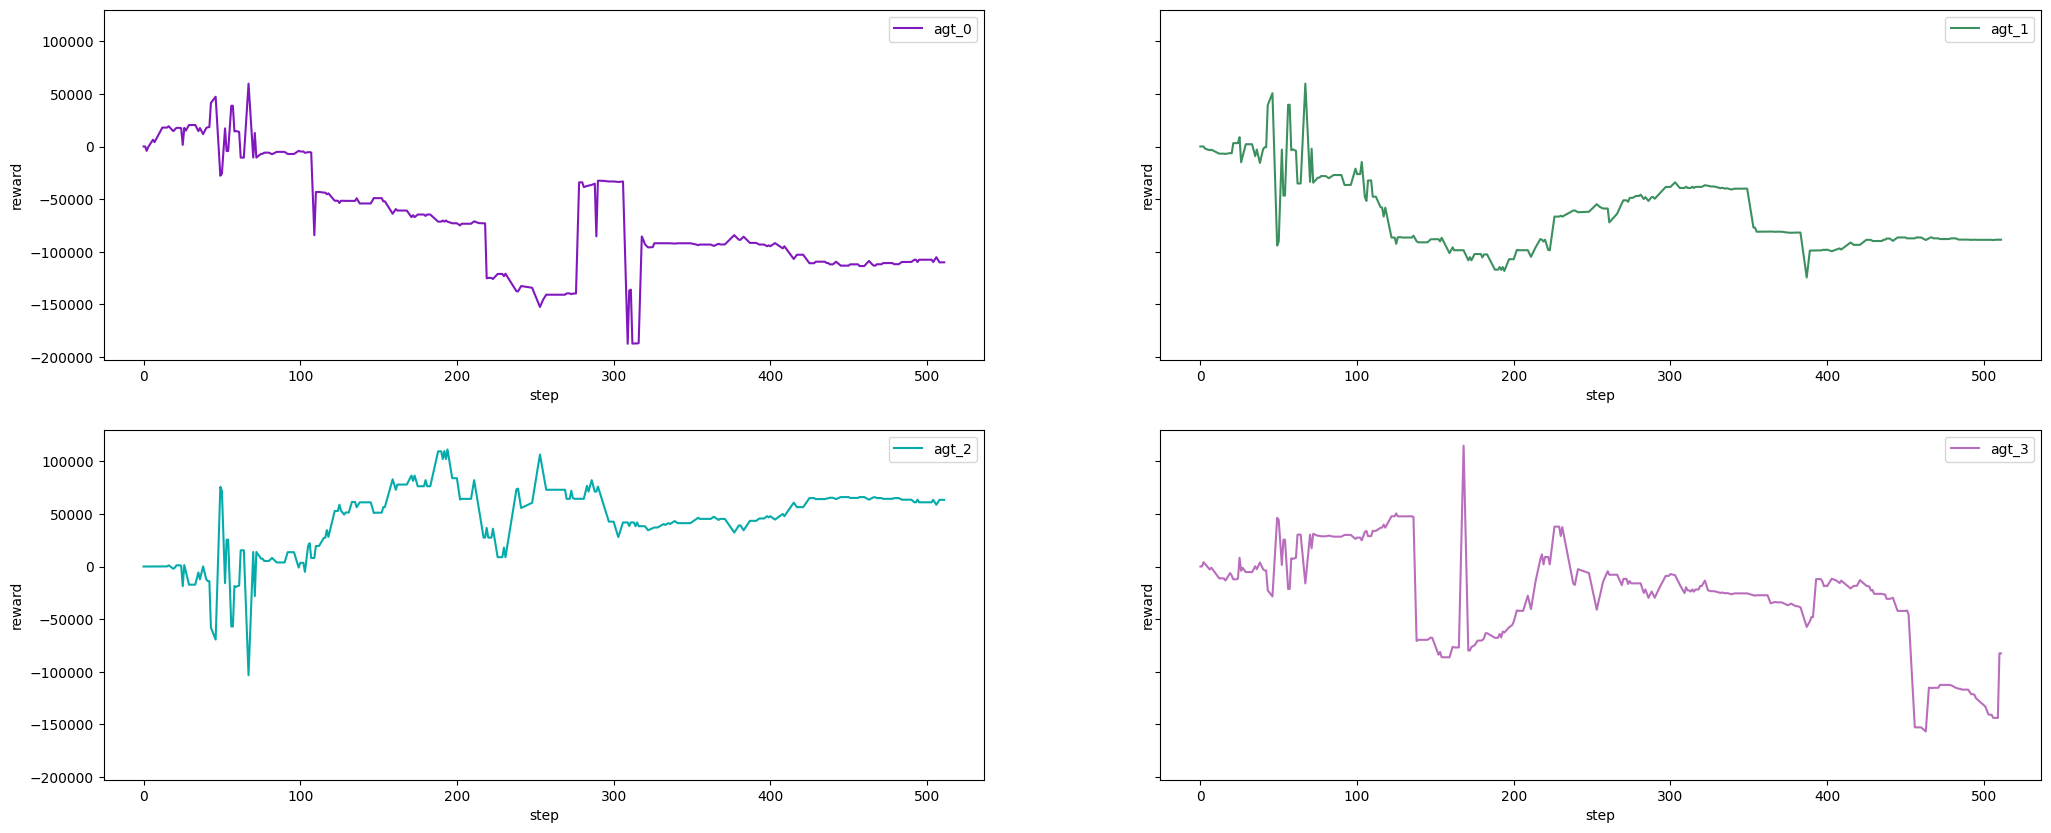

In [16]:
plot_storage(num_agents, init_cash)

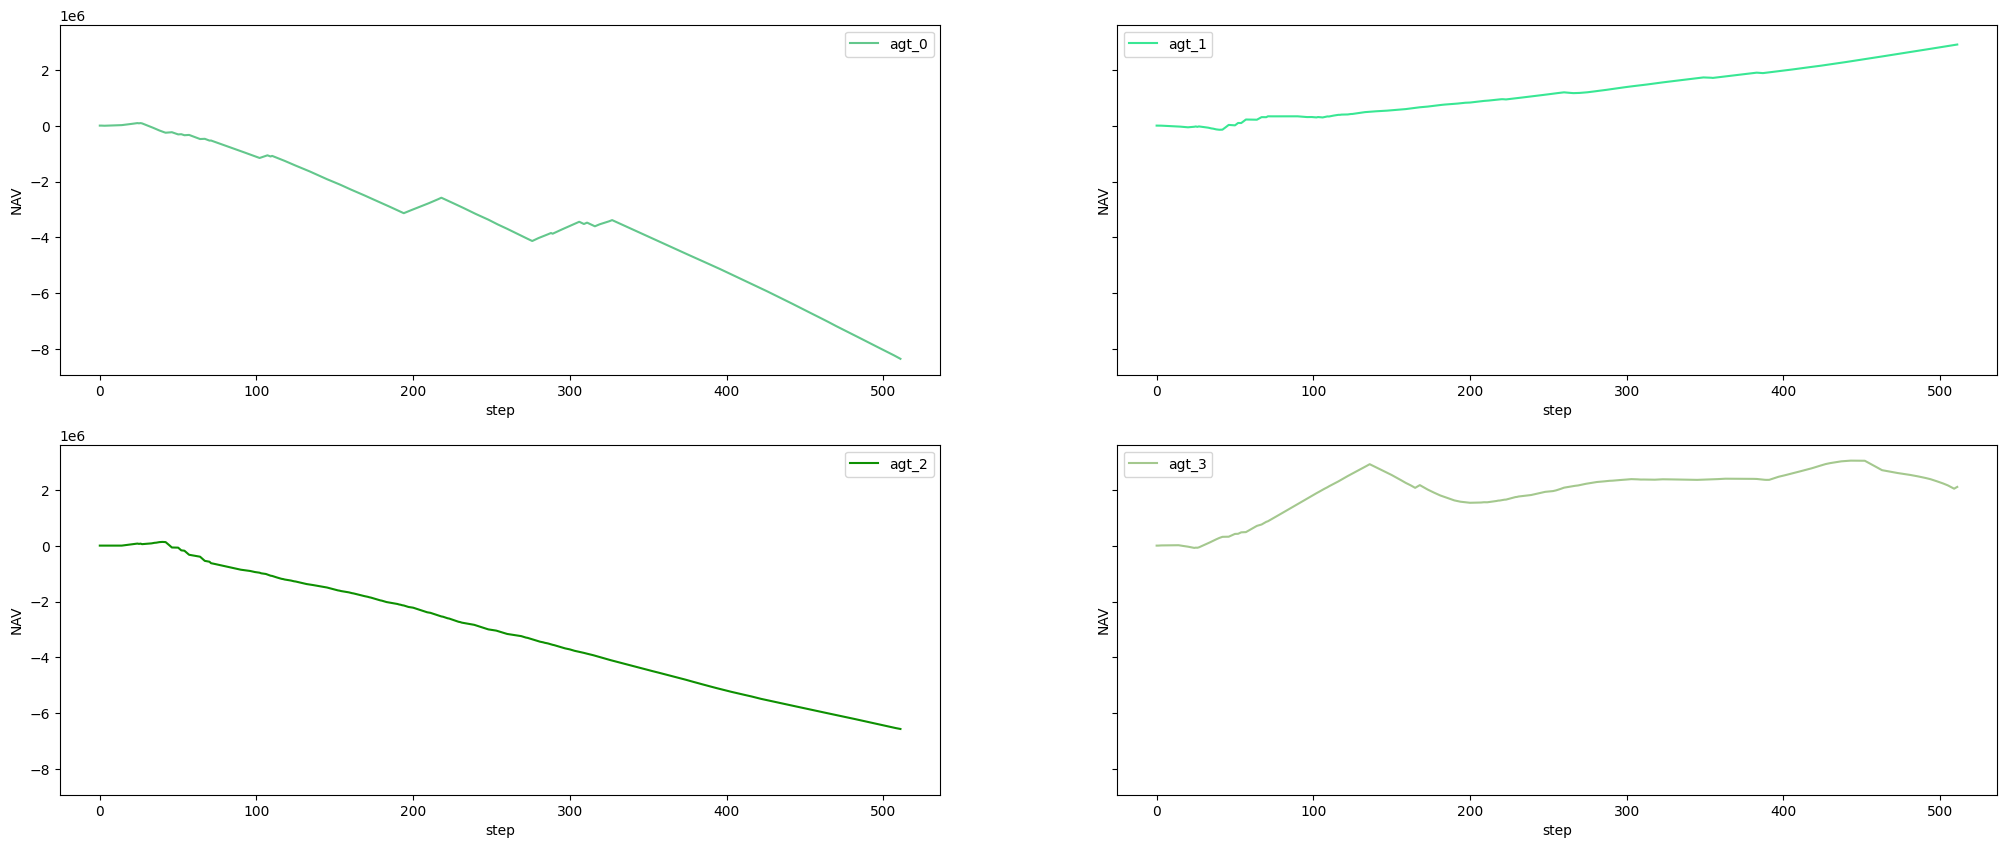

In [17]:
plot_storage(num_agents, init_cash, "step", "NAV")

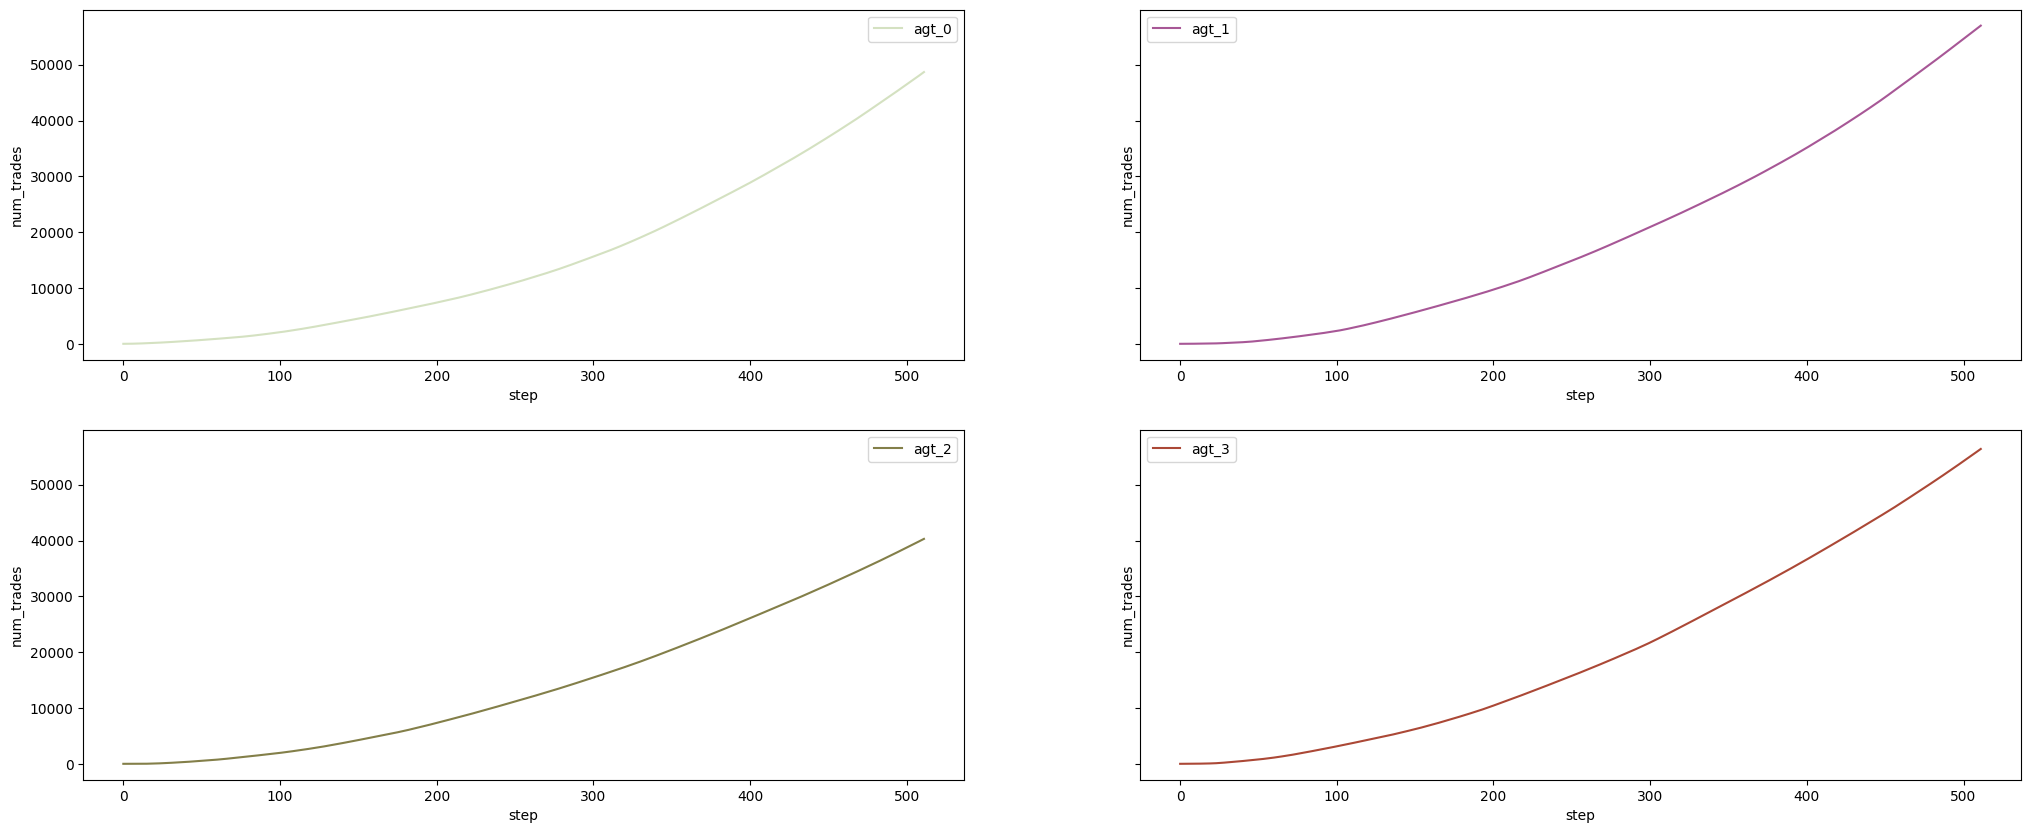

In [18]:
plot_storage(num_agents, init_cash, "step", "num_trades")

# Log/load last episode

In [19]:
log_g_store(log_g_store_dir, num_agents, experiment_id)
load_g_store(log_g_store_dir, num_agents, experiment_id)

00afe0e78662417b87f2c0fe04e3fe7c.gzip
0385b90486ff4149a1c978b294a73d08.gzip
08f3f13a2ece40128678949e15c8a8b1.gzip
0a0f5e6f2ae34e5c9fb8c7bdb1572ab9.gzip
0d4c5e2588d449f3a9a8b10aff097a61.gzip
0e4f162575c742b1a1ec40af12ebc626.gzip
0f4587dfc12e451ab2a074b78a44f3af.gzip
0fa1a29ea2e14f3ab4b411c12d7aa3ed.gzip
150abe01fc0e4f29a502241757916cdf.gzip
15ad055a9ab449e1a3dead879775ffbf.gzip
2057fcb146d04902ba31fa4c39492f38.gzip
25cd95f3666d4252a867e6a3ba581522.gzip
2ae300a7de9b419e8d6e61c9ea154291.gzip
33eed239ba9740b6888087ac93bfa5c9.gzip
345cc2c2c6ca430f920d7a17592e4d27.gzip
3493bded84ca4f128ffe2b3676d76315.gzip
35bf73617fd846678be8a9cbc91d8ec7.gzip
3c79c5d43cf346988f7245134bf82ca1.gzip
3ec22deaaaeb42ea9131552010eac7a0.gzip
413628f4363c45db895d179e44179f26.gzip
4197344ced6241b6bf4287c2df8cc5b9.gzip
423aee01046d4c02a68c1e060682d3ef.gzip
4277764e611e40cfa6d06f542a78a3b3.gzip
435481bec7a44504a2e0e7c6504303d2.gzip
44480f03a54f4bf0a82dea2ece90f473.gzip
45a5d80924b141a192b8a250bb461f49.gzip
48cd3c6aee8e

# Plot steps from last episode.

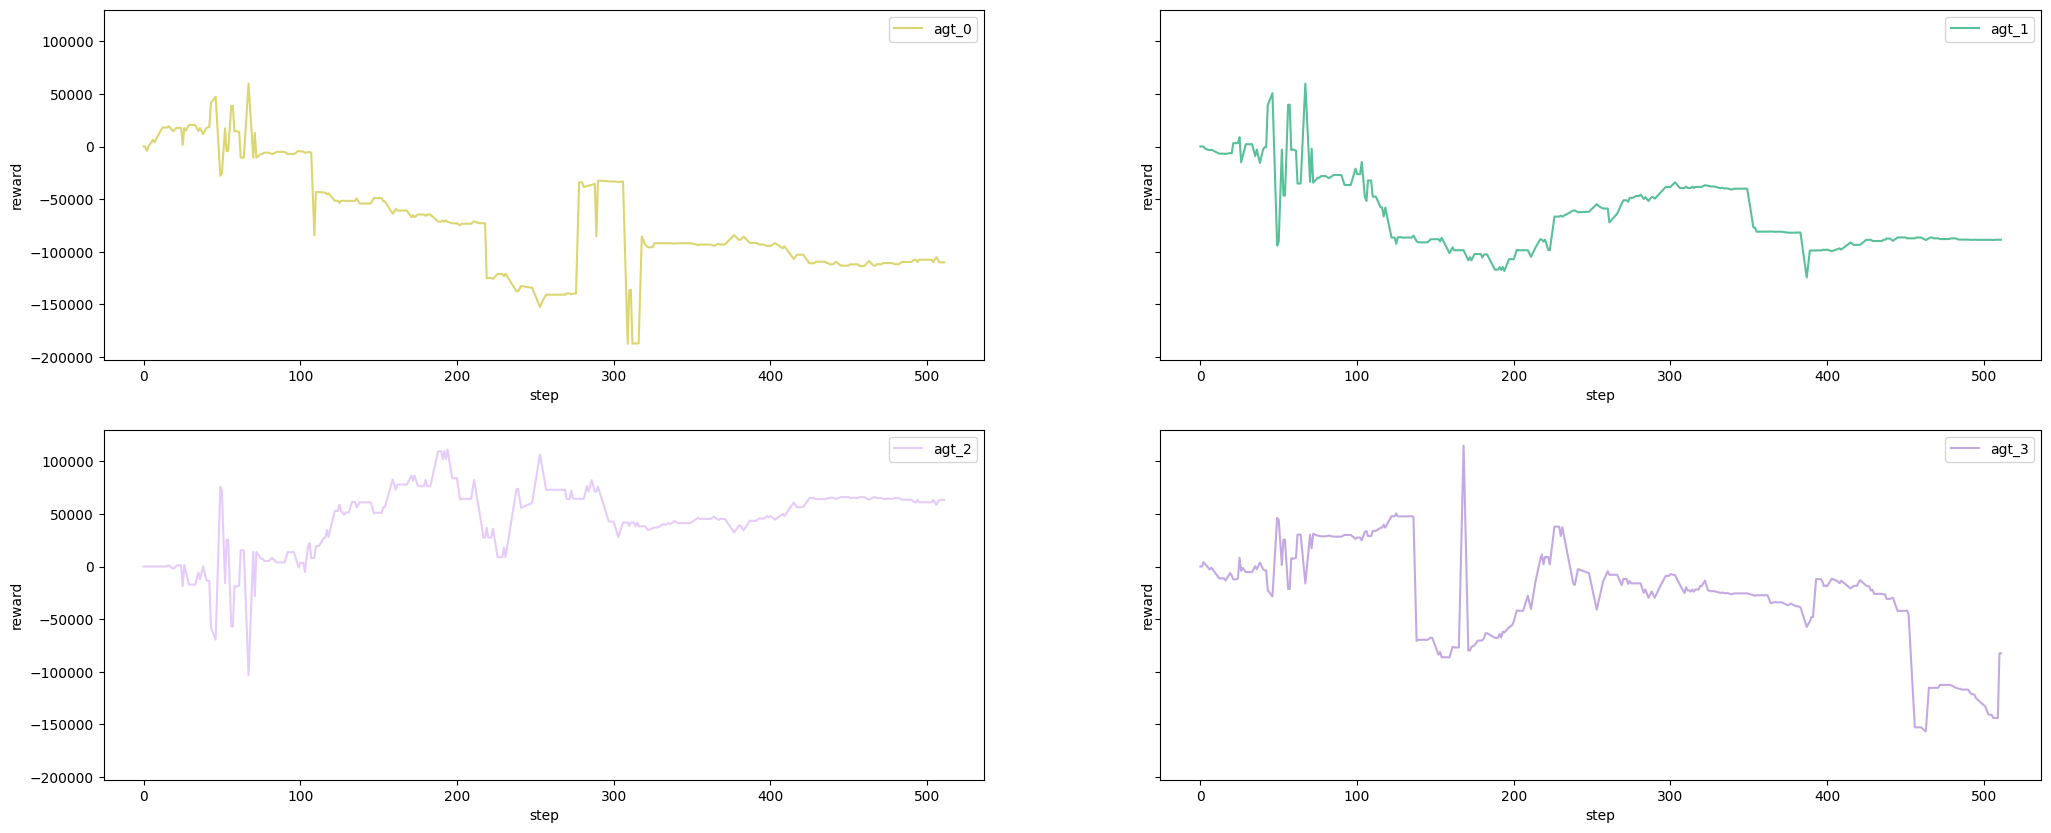

In [20]:
plot_storage(num_agents, init_cash)

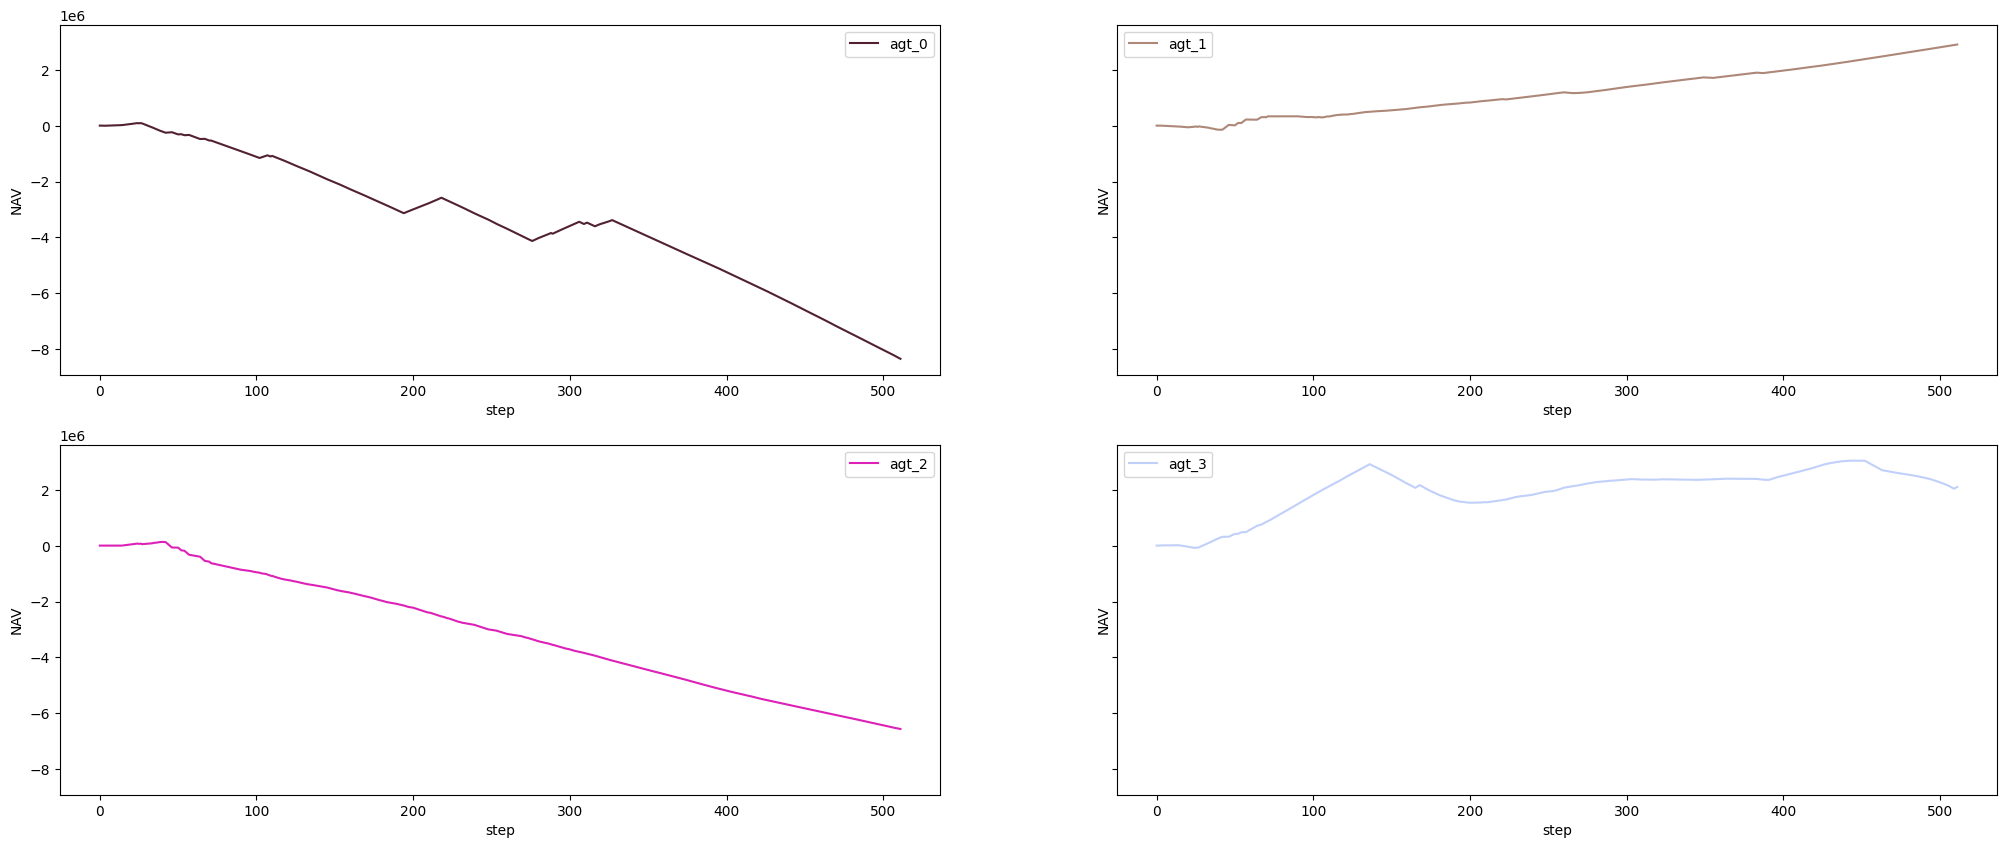

In [21]:
plot_storage(num_agents, init_cash, "step", "NAV")

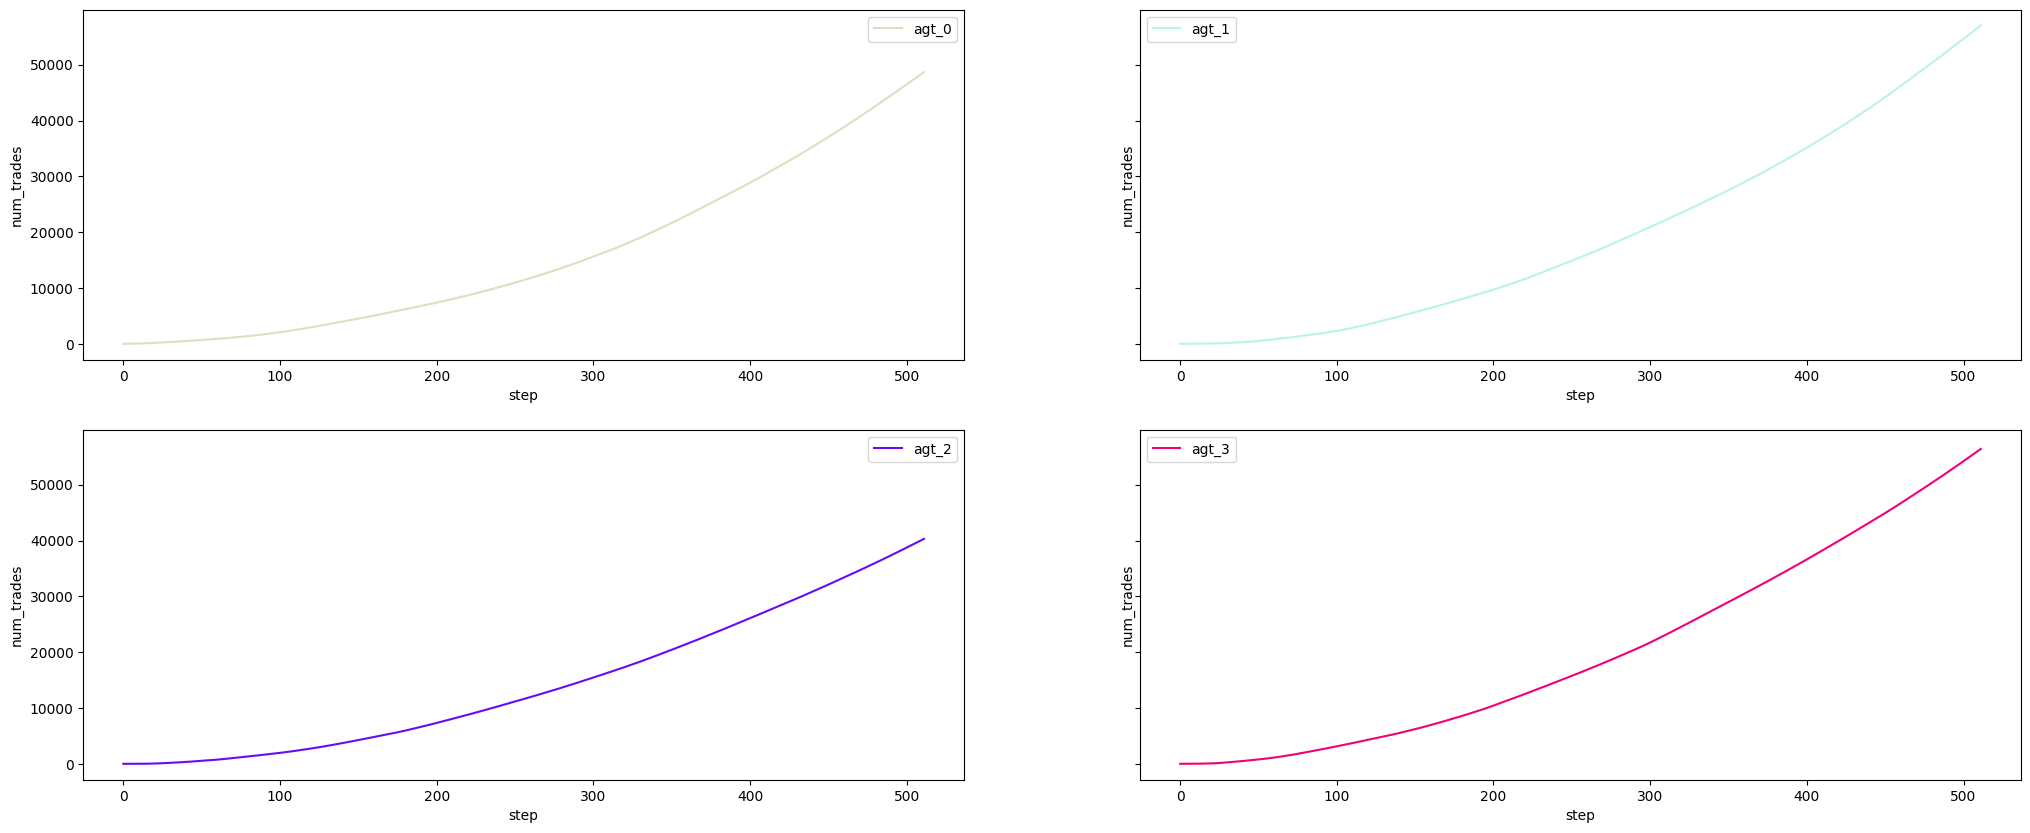

In [22]:
plot_storage(num_agents, init_cash, "step", "num_trades")

# LOB from last episode.

In [23]:
# g_store = ray.util.get_actor("g_store")          
g_store = ray.get_actor("g_store")          

#store = ray.get(g_rere.get_storage.remote())

depth = 10
bid_size, bid_price, ask_size, ask_price = ray.get(g_store.get_obs_from_agt.remote(0, depth))

# LOB order imbalance

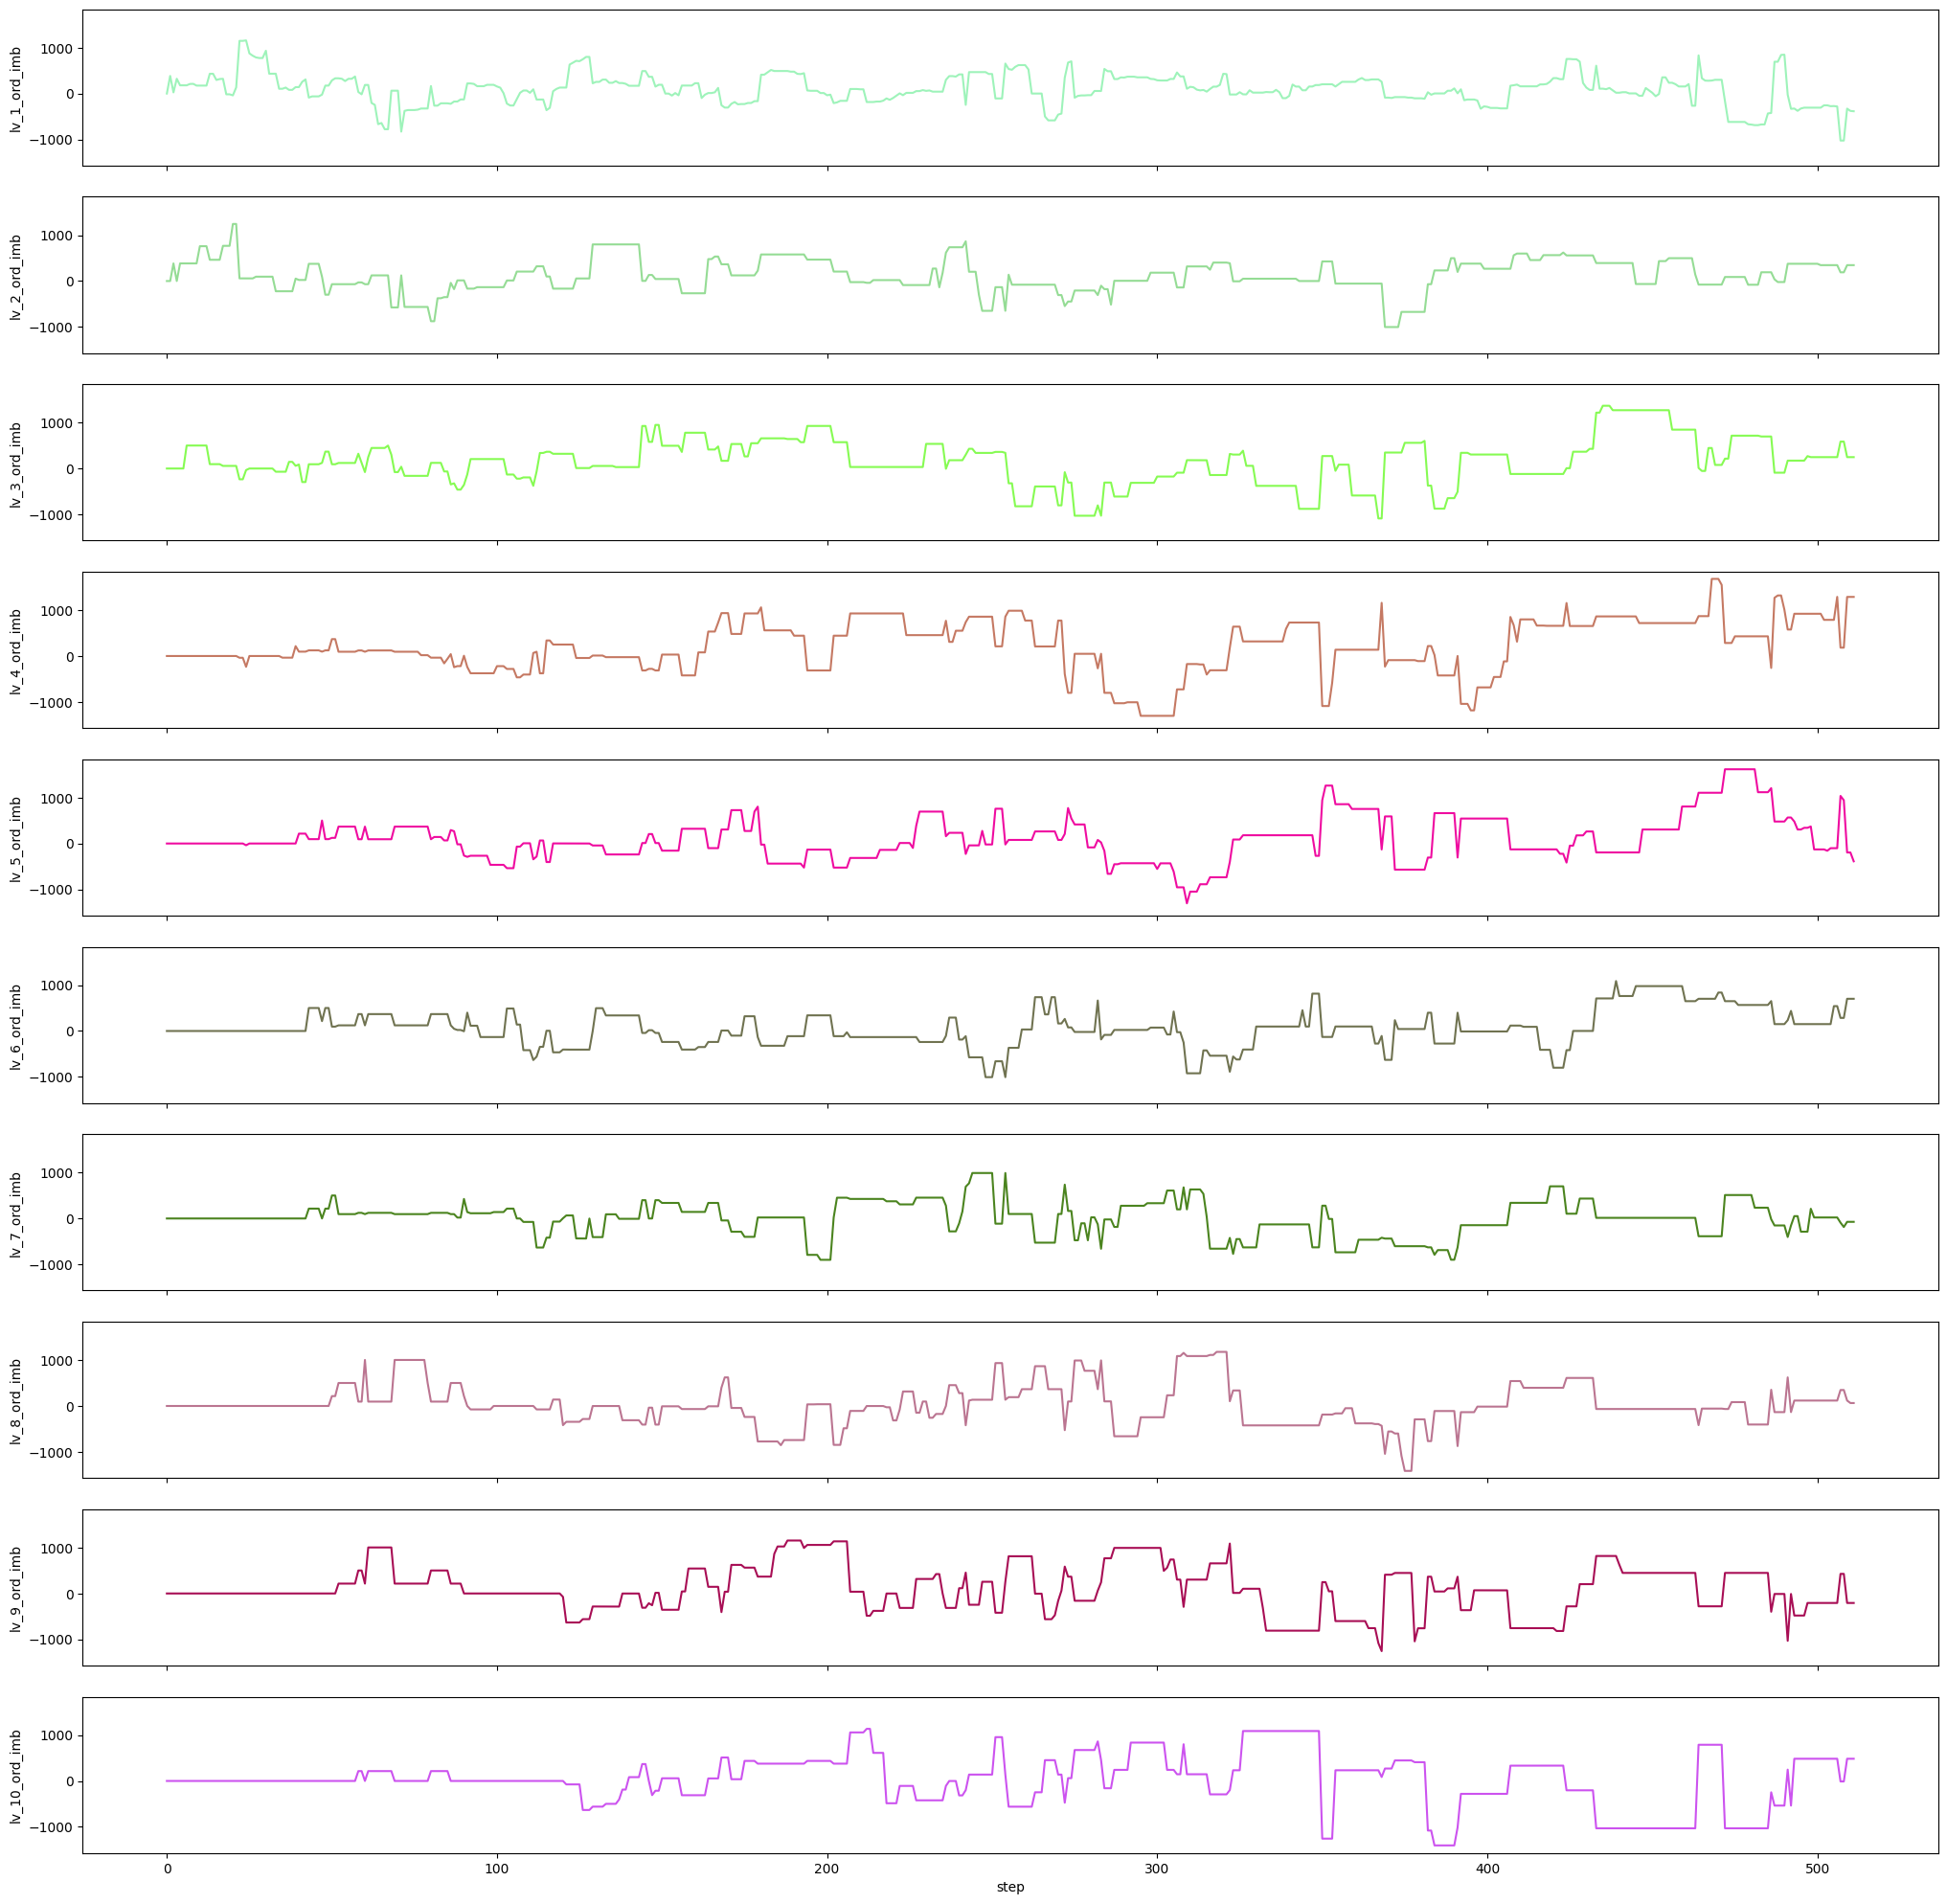

In [24]:
ord_imb_store = ord_imb(bid_size, ask_size)
plot_LOB_subplot(ord_imb_store, depth, '_ord_imb') 

# LOB sum of order imbalance

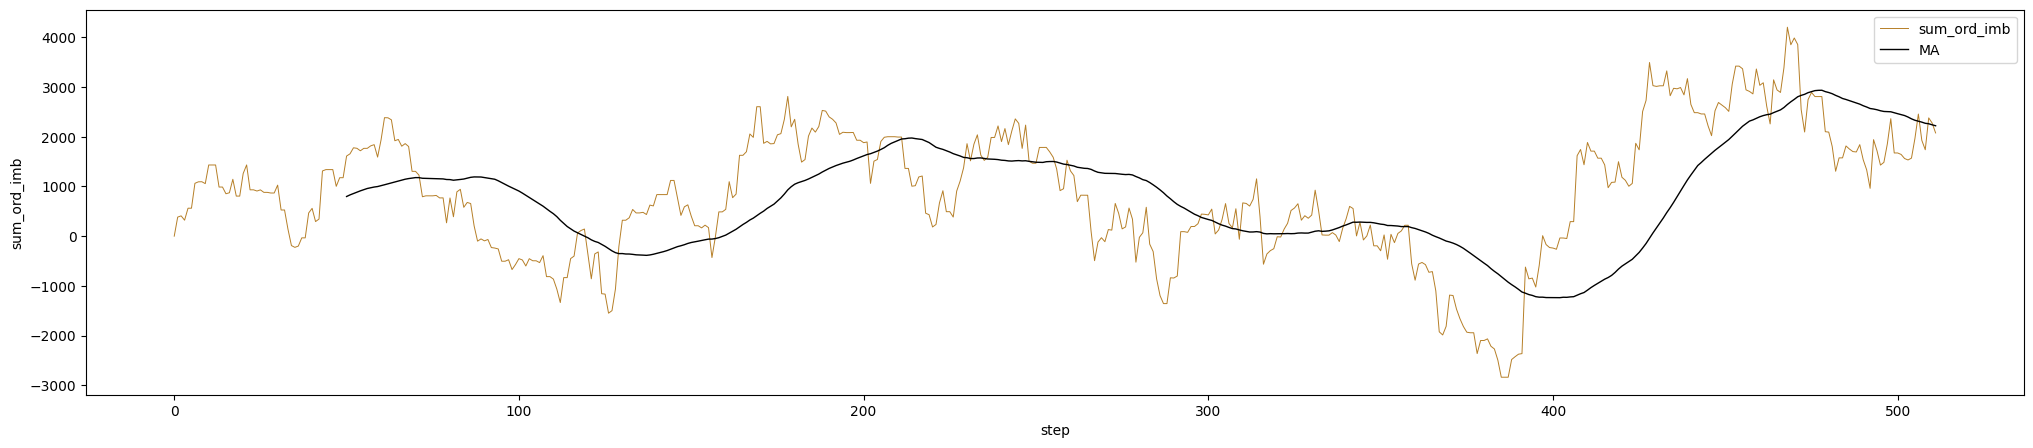

In [25]:
ord_imb_store = np.asarray(ord_imb_store)
sum_ord_imb_store = sum_ord_imb(ord_imb_store)
plot_sum_ord_imb(sum_ord_imb_store, "sum_ord_imb")

# LOB mid price (subplot)

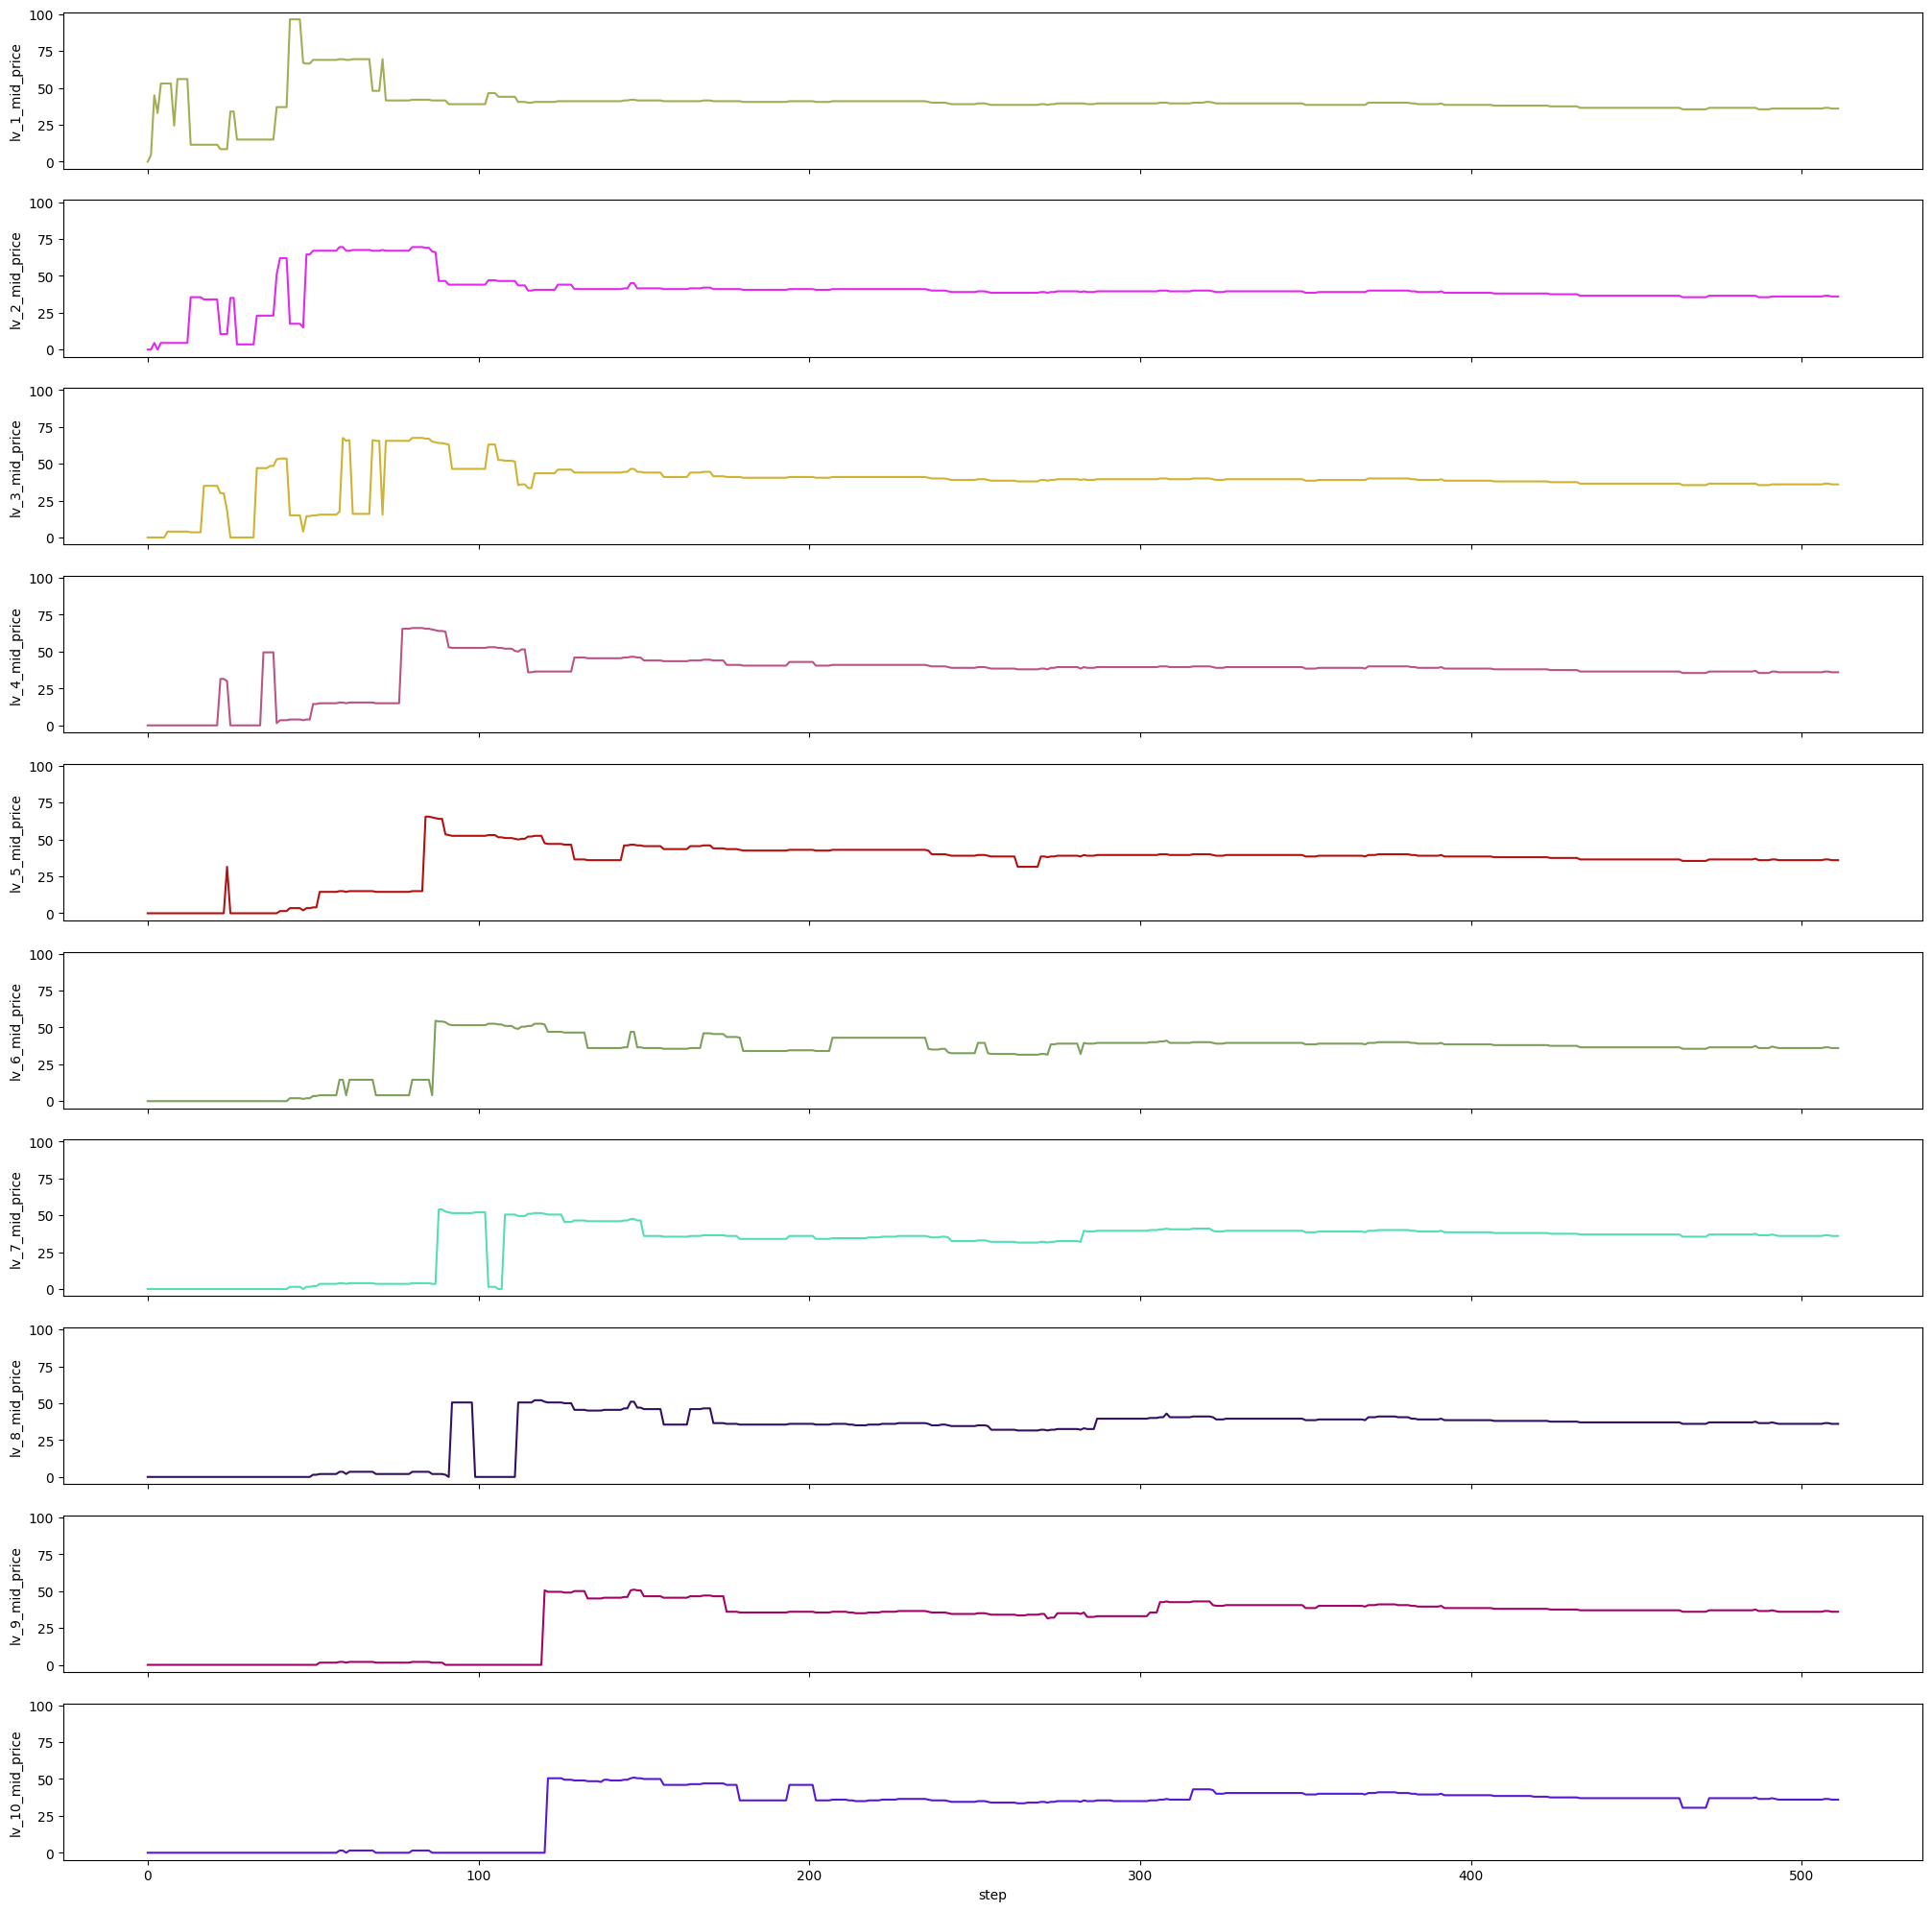

In [26]:
mid_price_store = mid_price(bid_price, ask_price)
plot_LOB_subplot(mid_price_store, depth, '_mid_price')    

# LOB mid prices 

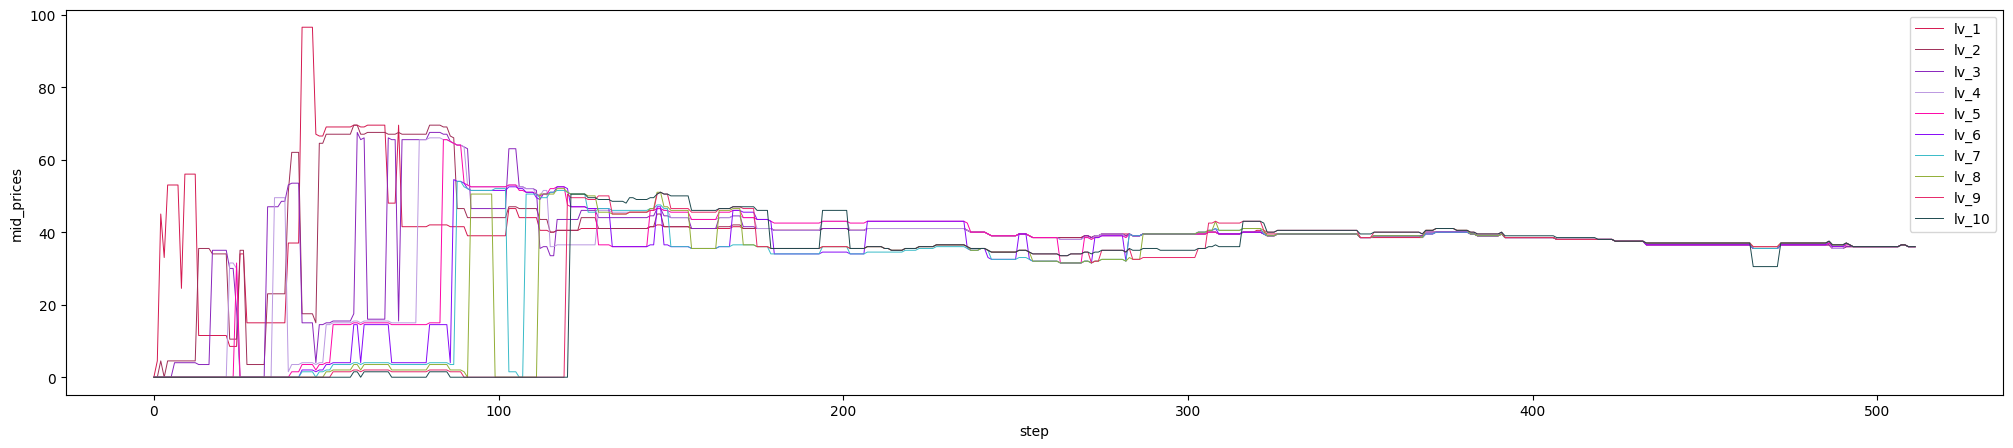

In [27]:
plot_mid_prices(mid_price_store,)

# LOB bid size

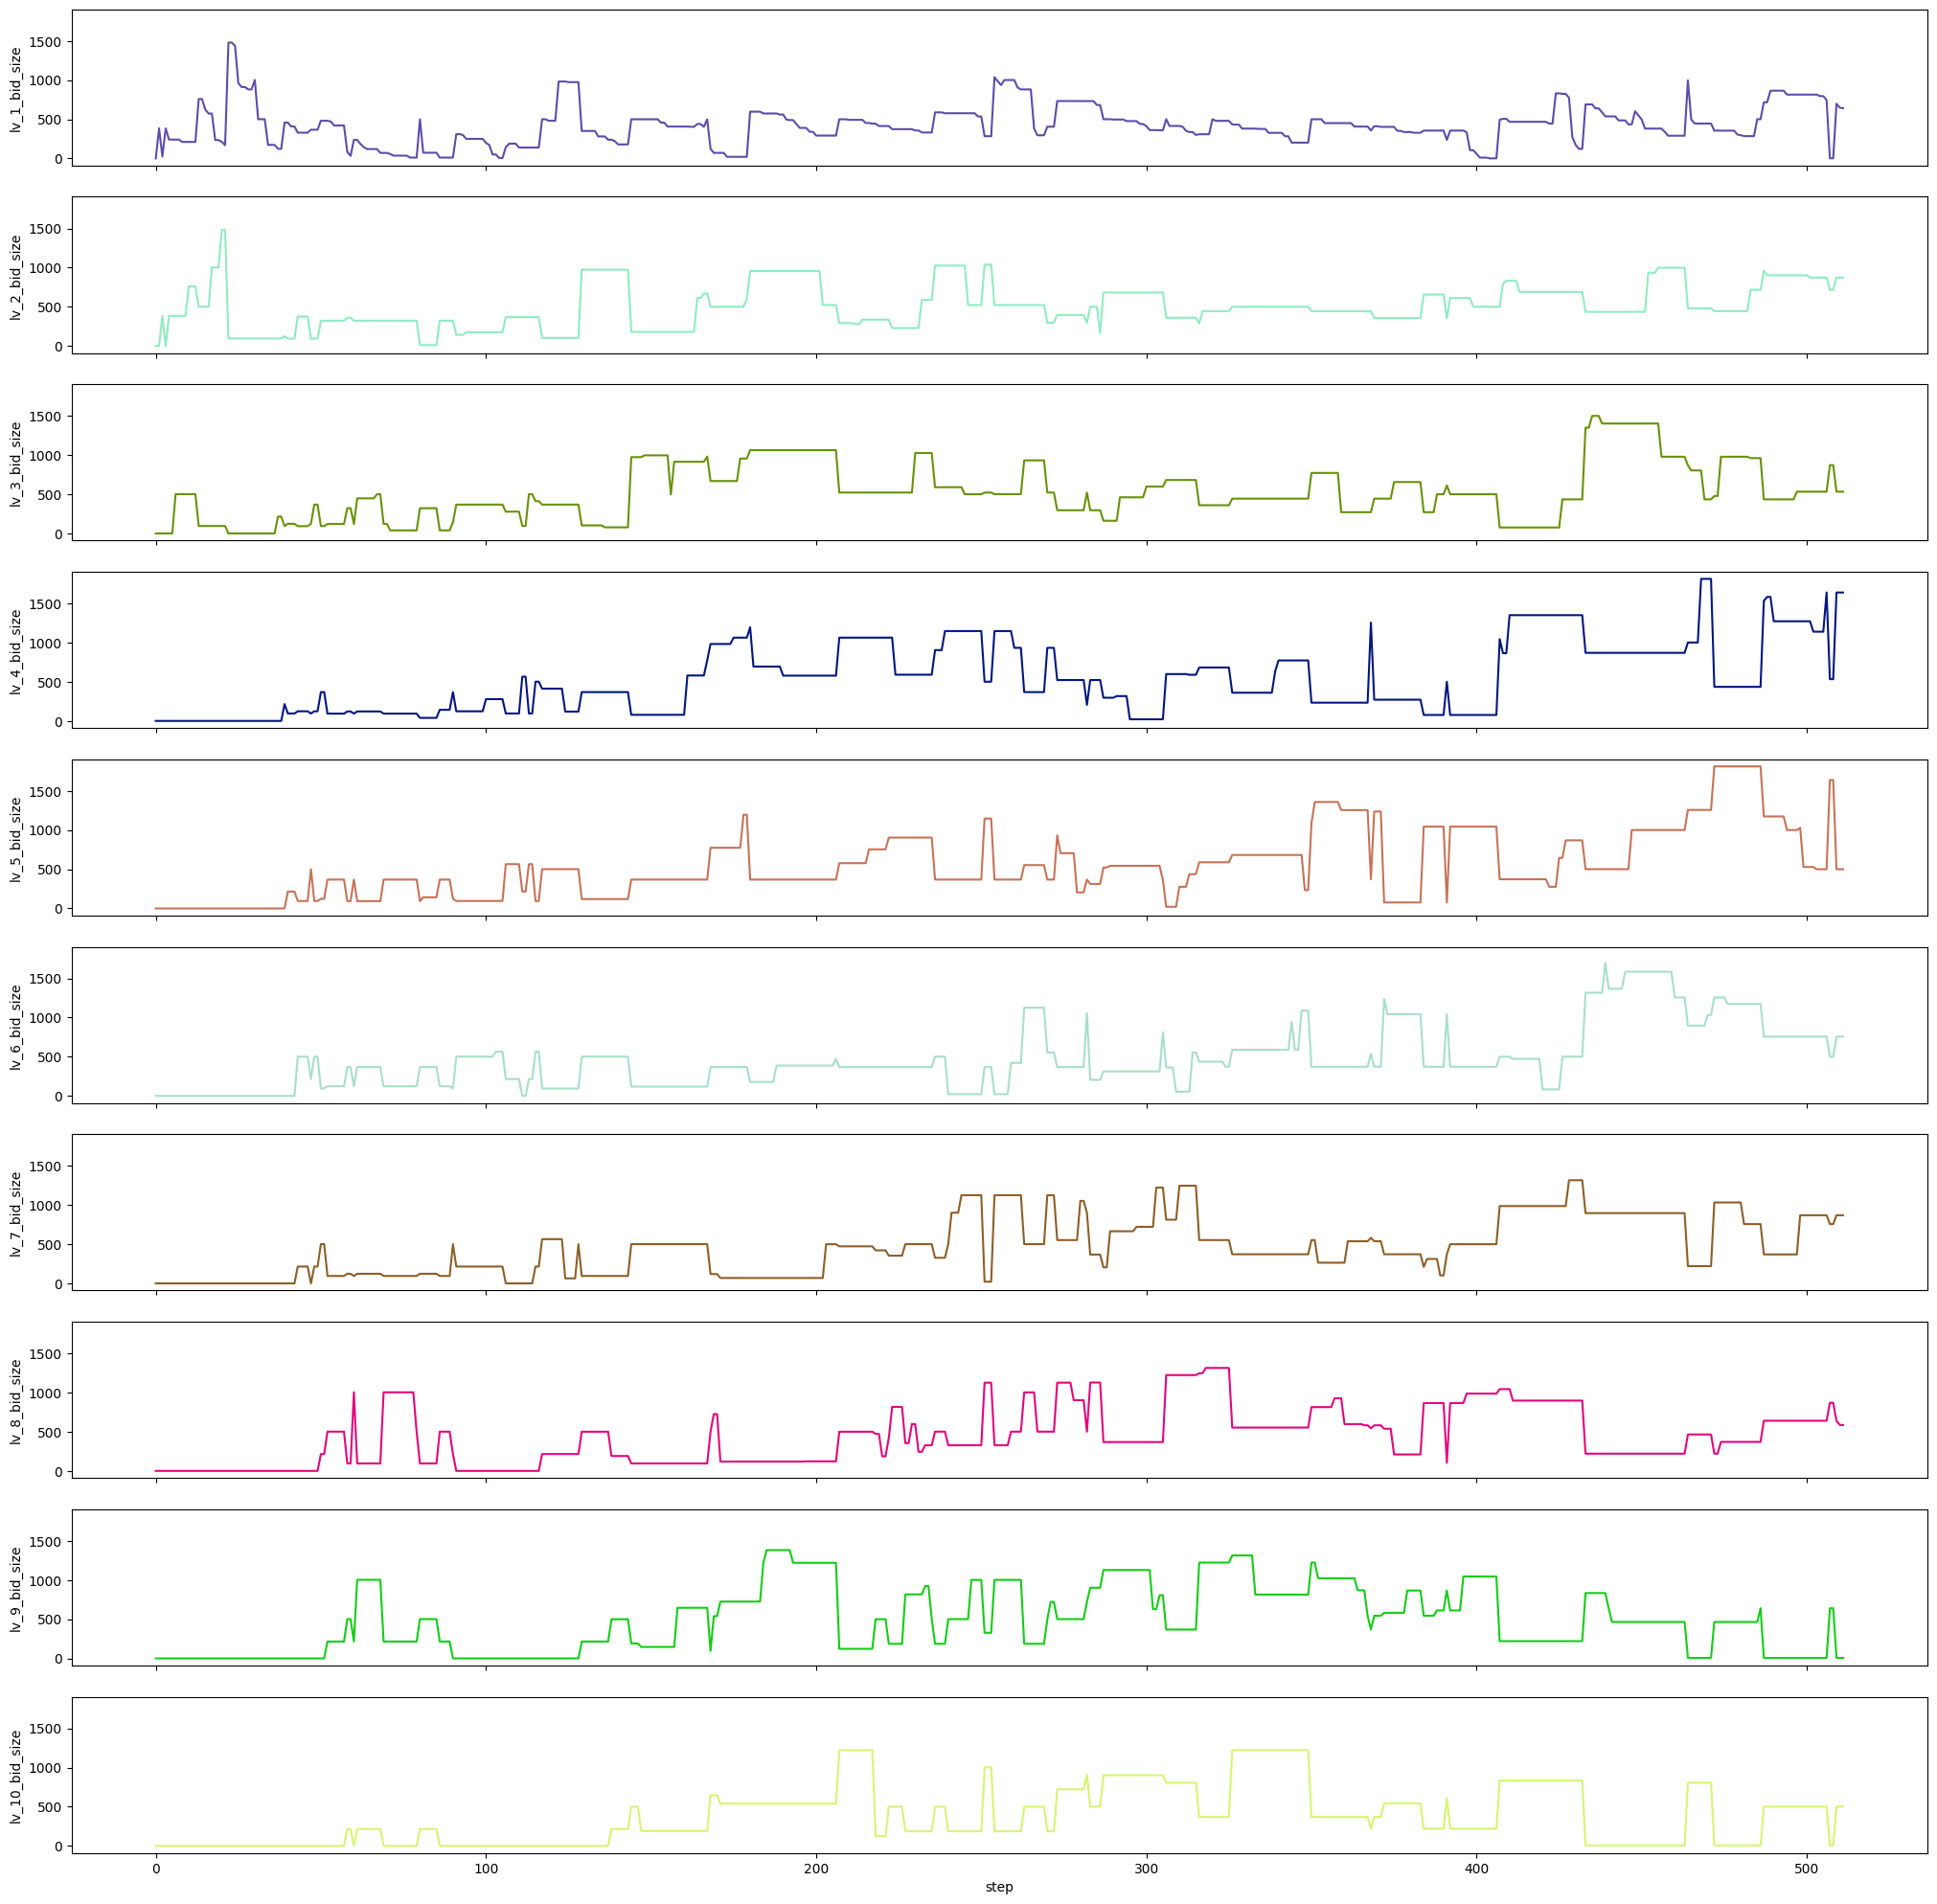

In [28]:
plot_LOB_subplot(bid_size, depth, '_bid_size')    

#LOB ask size

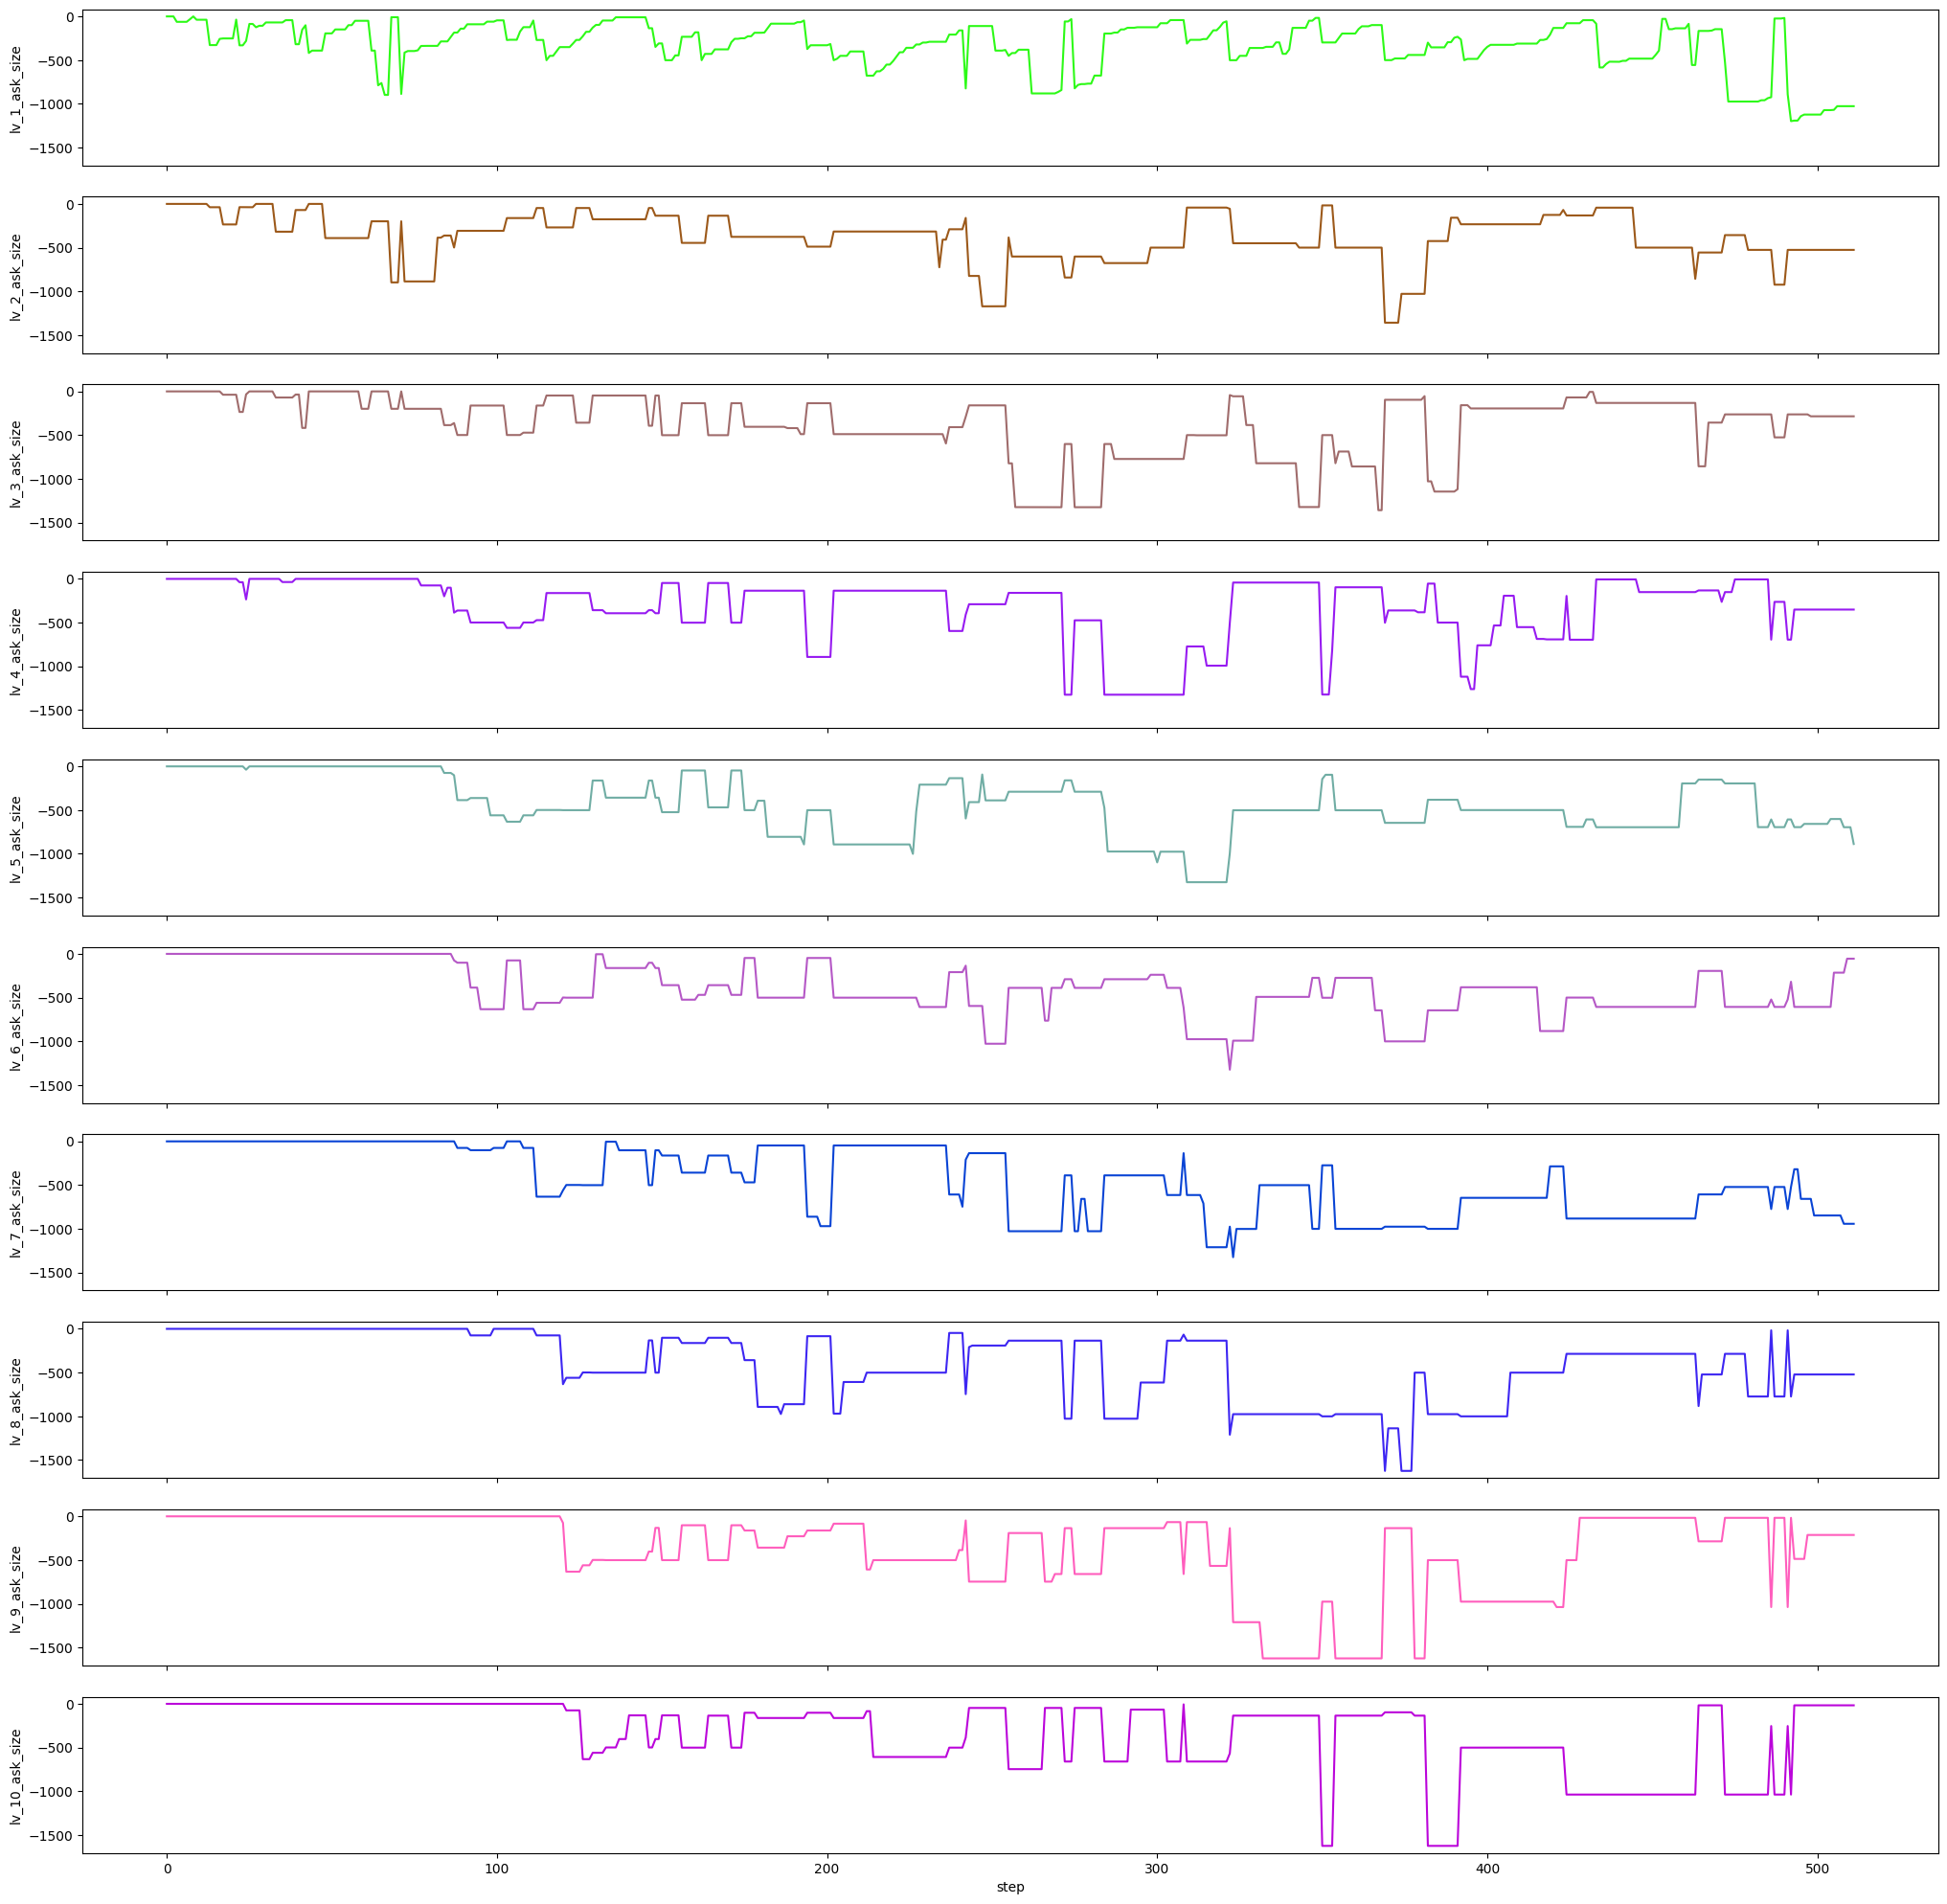

In [29]:
plot_LOB_subplot(ask_size, depth, '_ask_size')    

# LOB bid price

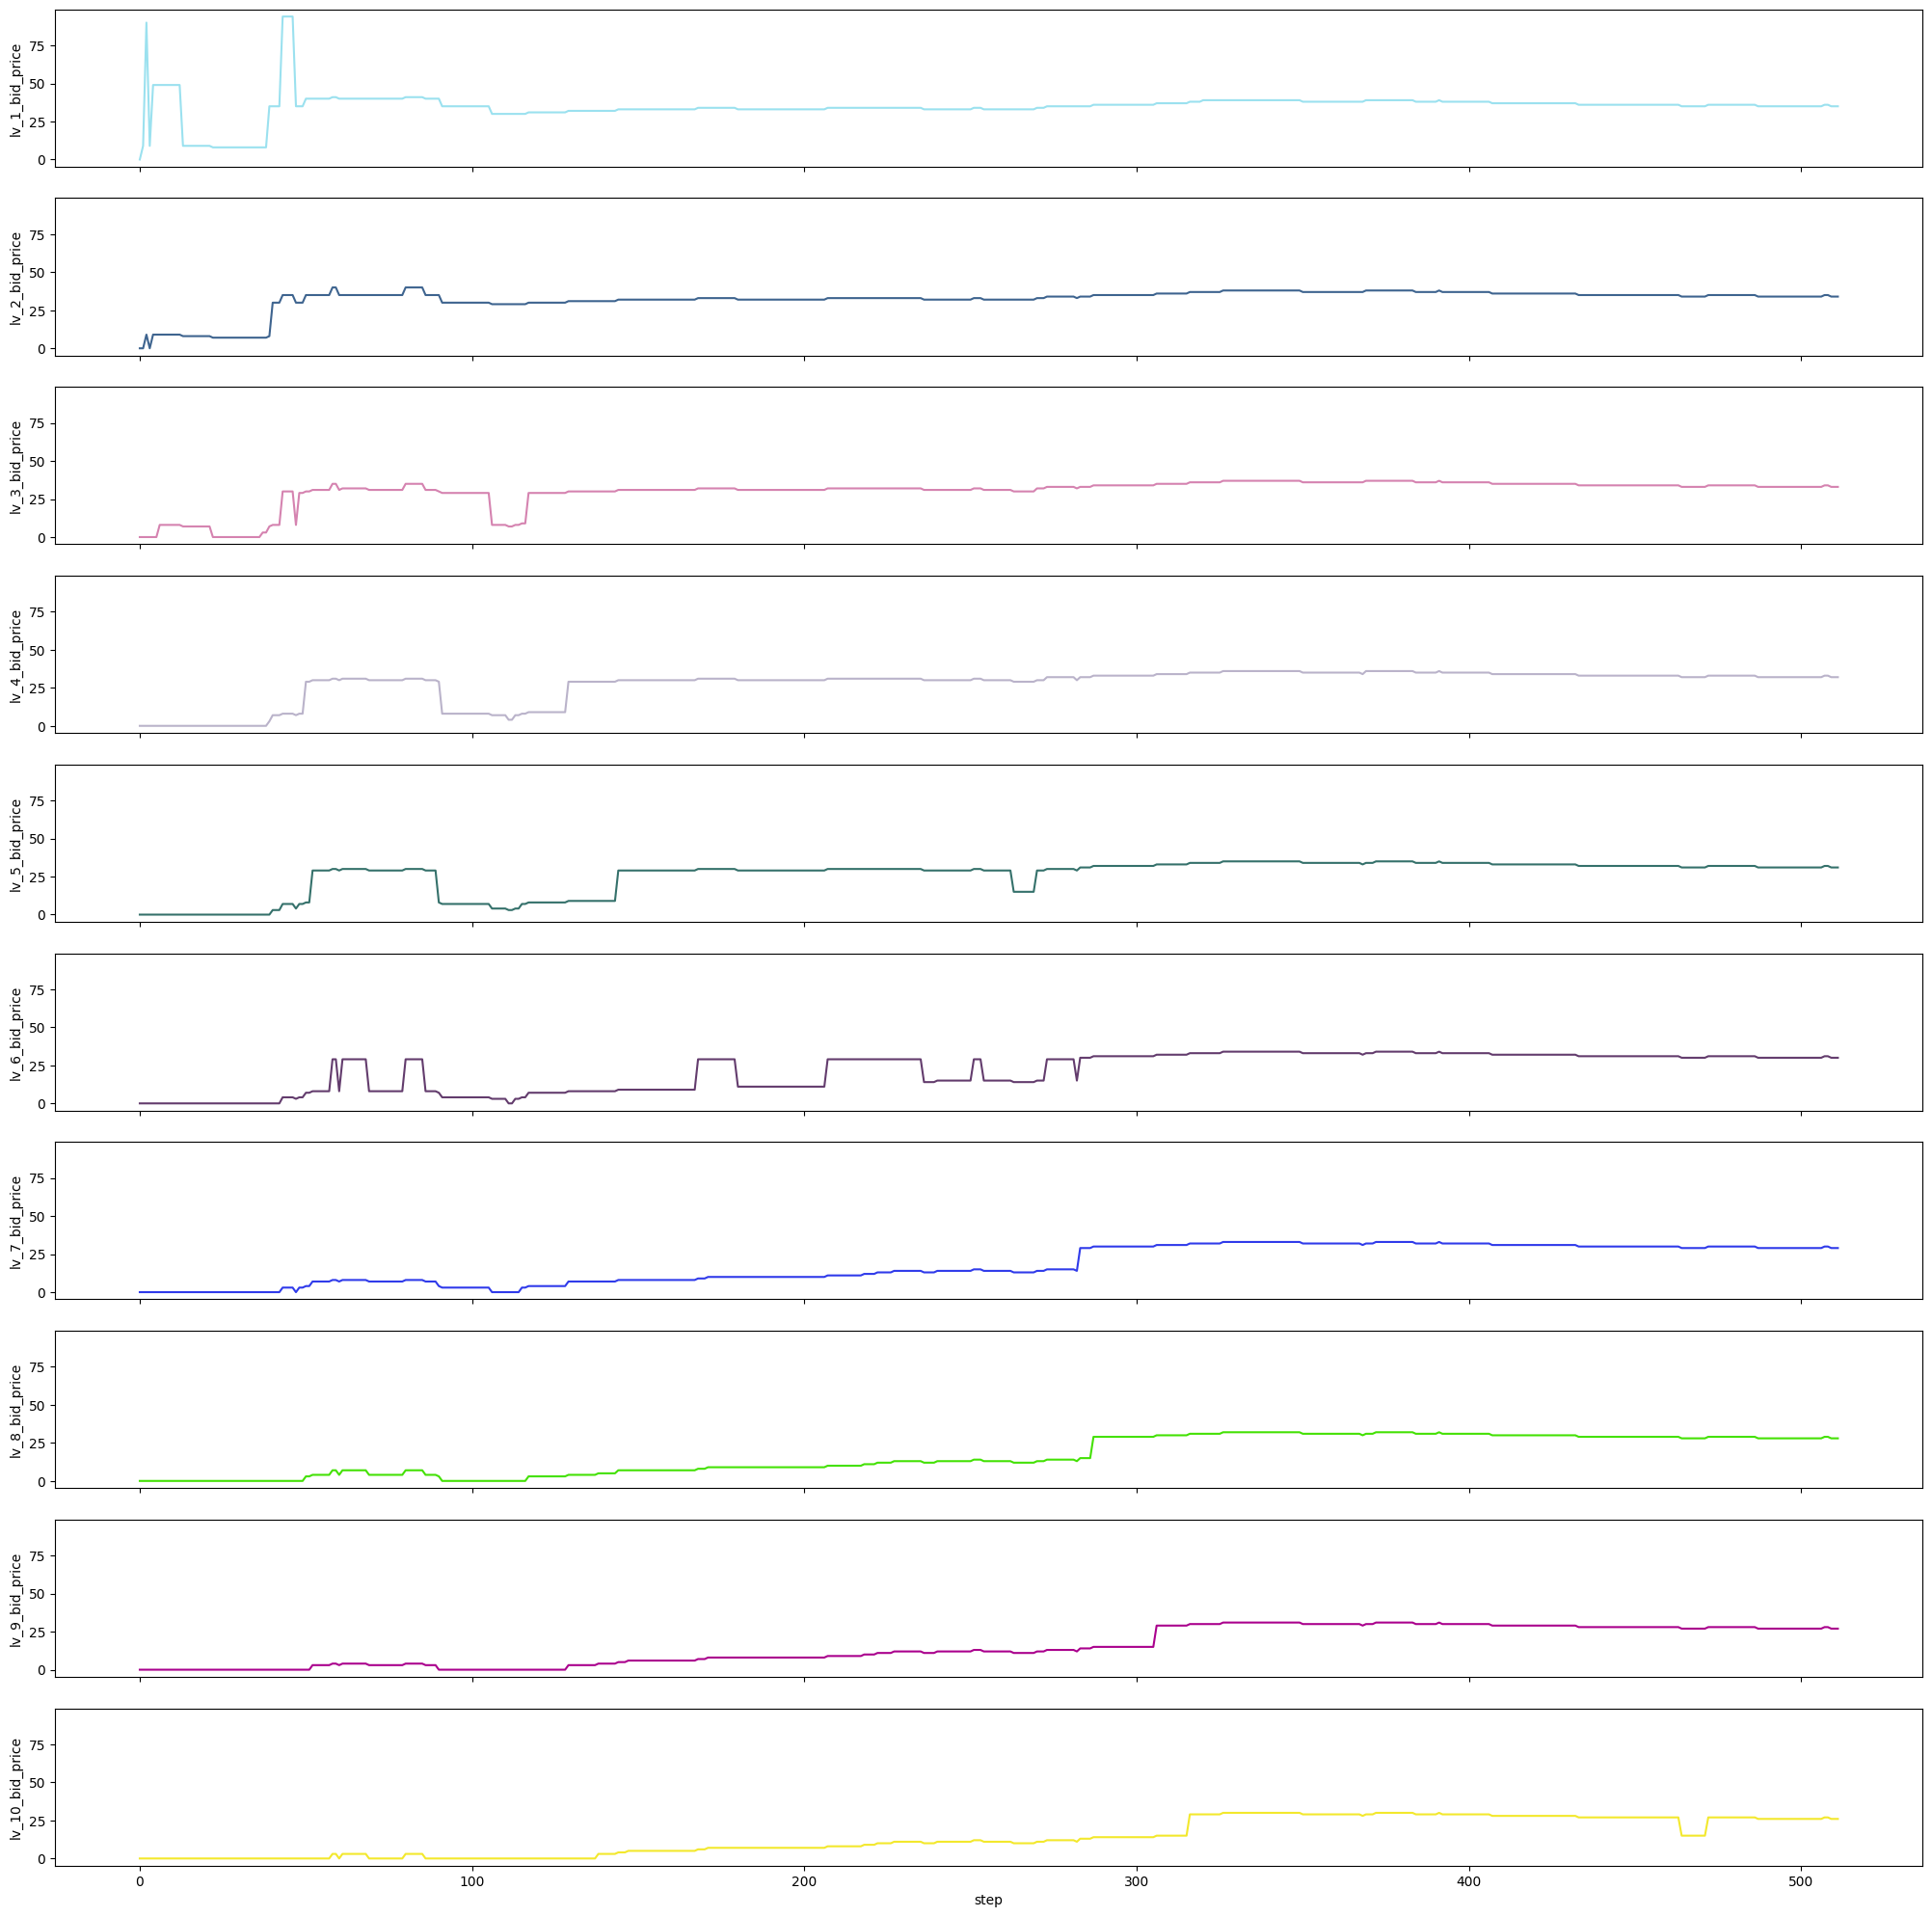

In [30]:
plot_LOB_subplot(bid_price, depth, '_bid_price')    

# LOB ask price

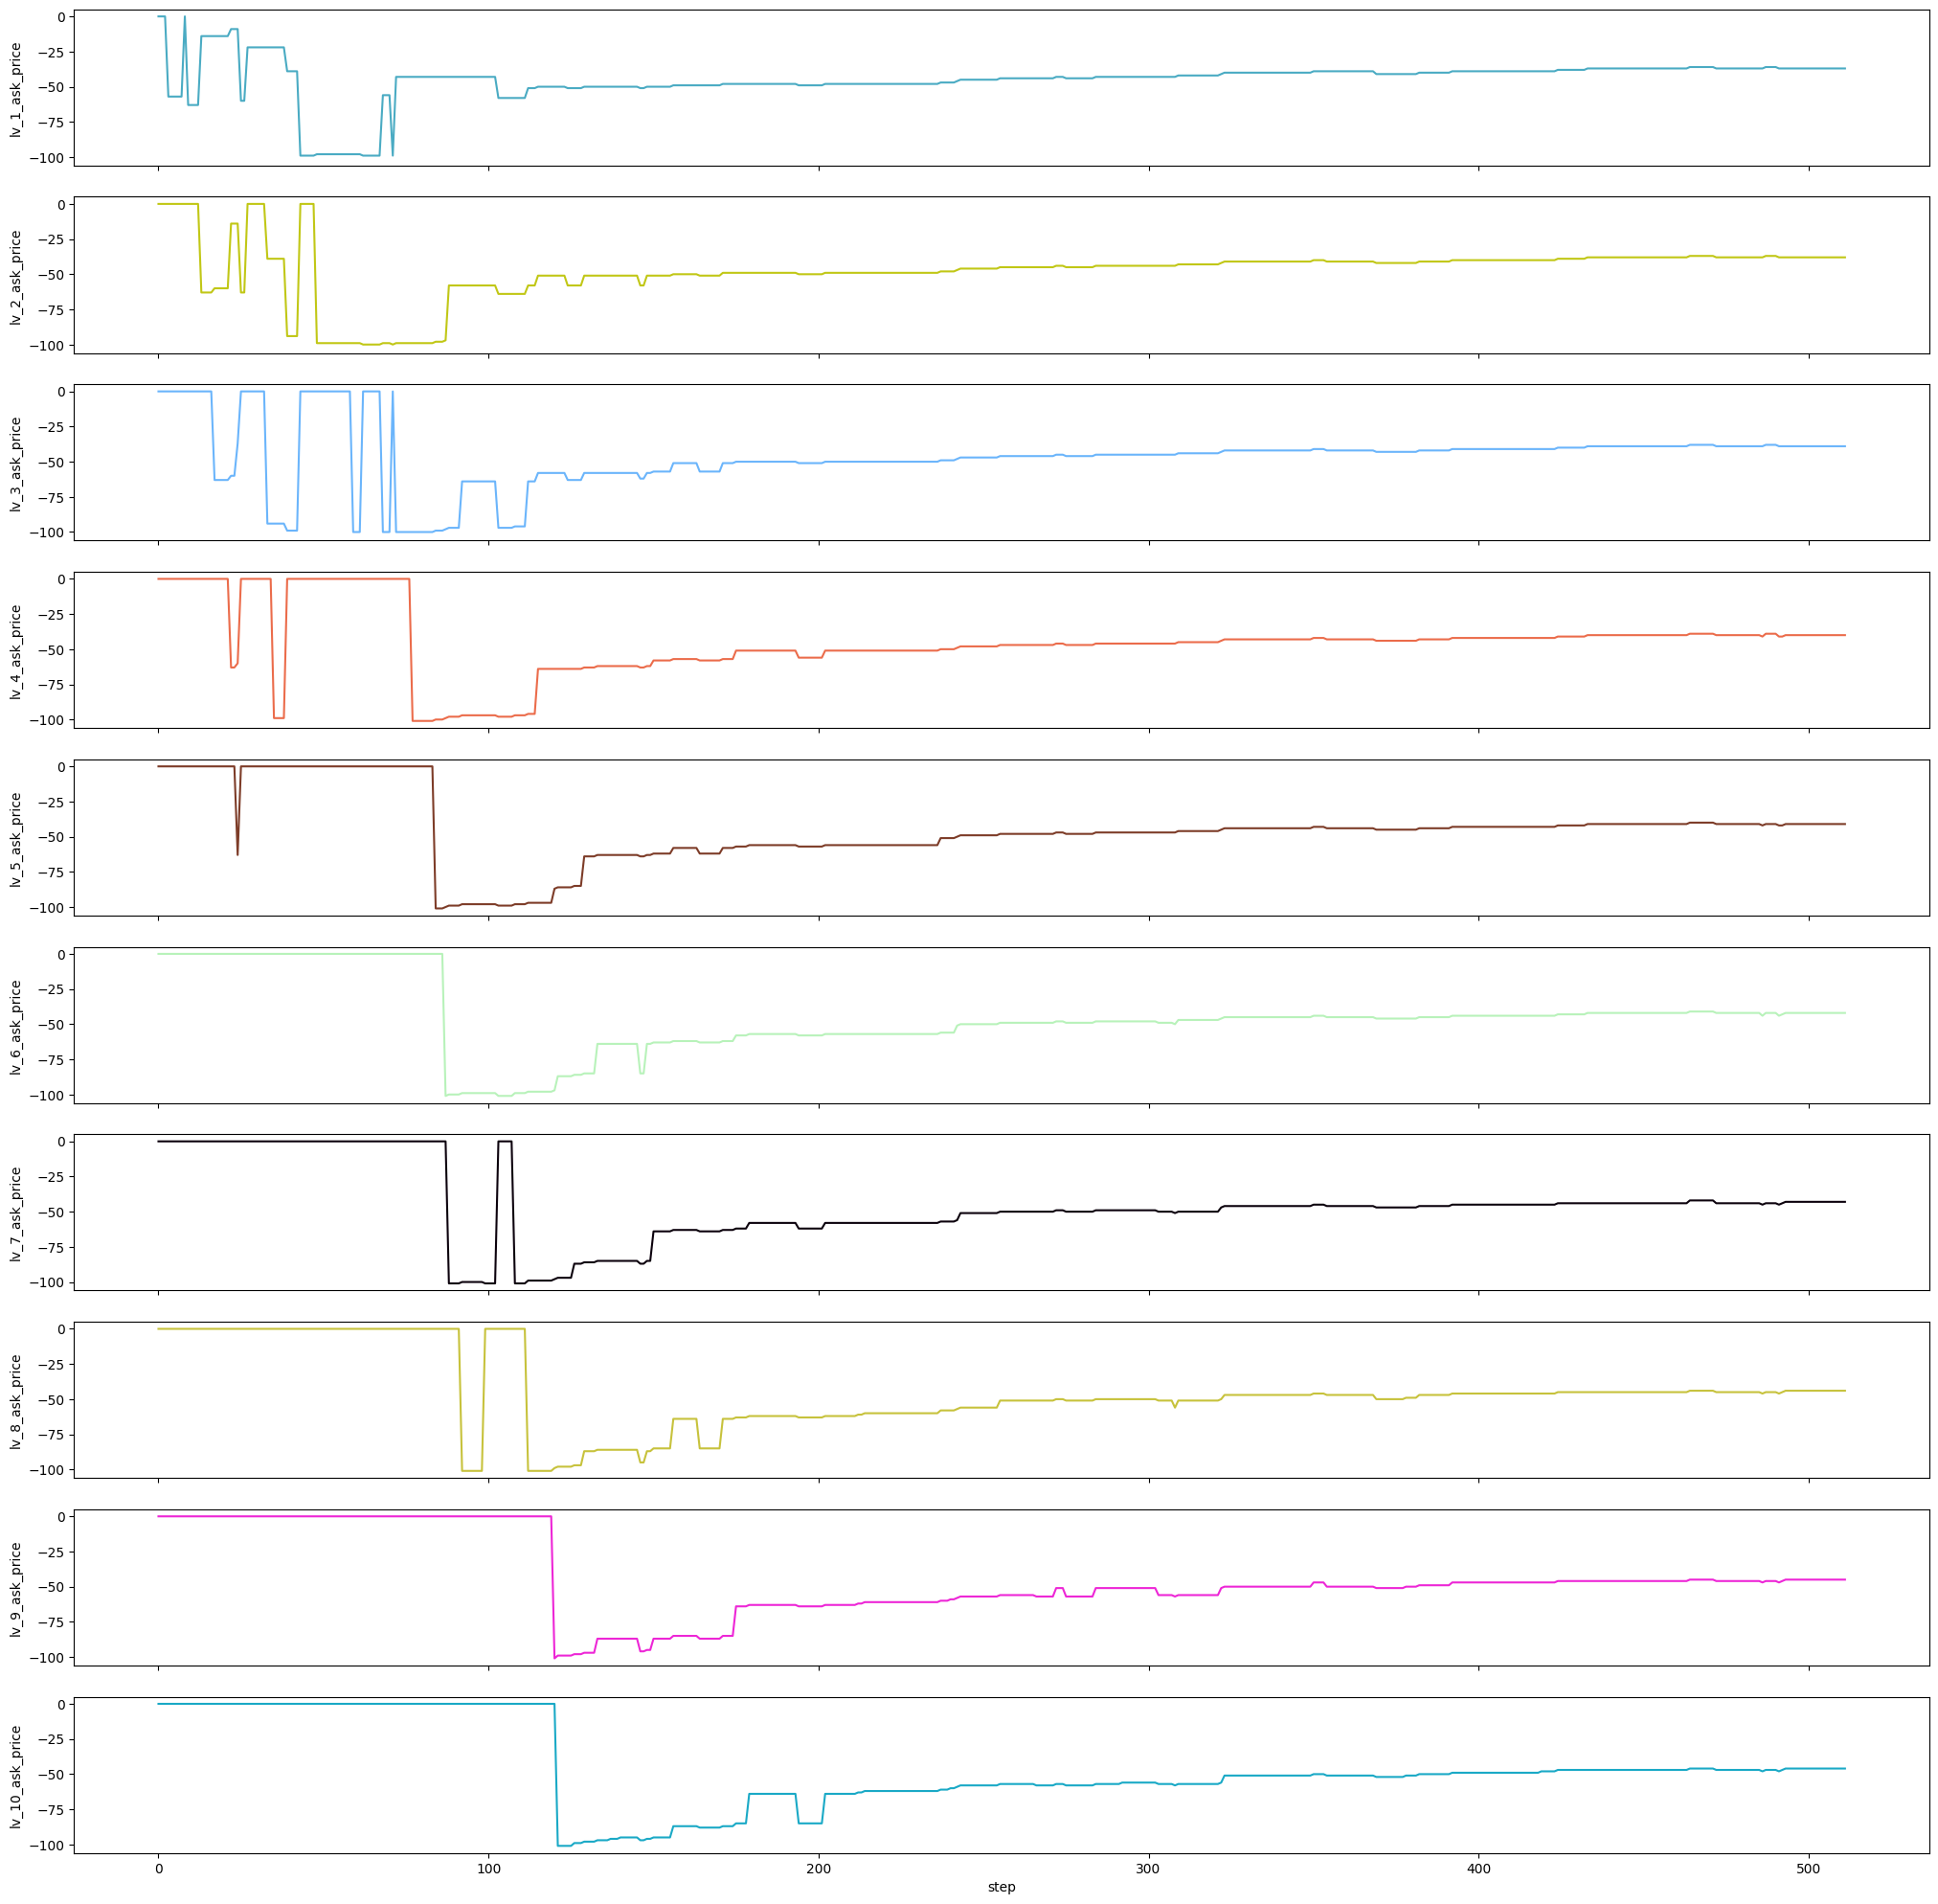

In [31]:
plot_LOB_subplot(ask_price, depth, '_ask_price')    